## Configuration & Stage Control

Set which phases to run. If restarting after timeout, set completed phases to `False`.

In [2]:
# =============================================================================
# PHASE CONTROL FLAGS - Set to True to run each phase
# =============================================================================

RUN_PHASE_1_PREPROCESSING = True      # Setup & Data Preprocessing
RUN_PHASE_2A_TRAIN_AE = True          # Train Autoencoder
RUN_PHASE_2B_EXTRACT_EMBEDDINGS = True # Extract Transformer Embeddings
RUN_PHASE_3_TRAIN_BASELINES = True    # Train Baseline Models
RUN_PHASE_4_TRAIN_HYBRID = True       # Train Hybrid Model
RUN_PHASE_5_EVALUATE = True           # Evaluation & Visualization

# =============================================================================
# GLOBAL CONFIGURATION
# =============================================================================

# Paths (adjust for Kaggle vs local)
KAGGLE_MODE = True  # Set to True when running on Kaggle

if KAGGLE_MODE:
    DATA_DIR = '/kaggle/input/'
    OUTPUT_DIR = '/kaggle/working'
else:
    DATA_DIR = './Dataset'
    OUTPUT_DIR = './output'

# Audio Processing Parameters
SAMPLE_RATE = 16000        # Target sample rate (Hz)
DURATION = 5.0             # Clip duration (seconds)
N_MELS = 128               # Number of mel bands
N_FFT = 2048               # FFT window size
HOP_LENGTH = 512           # Hop length for STFT
MAX_SAMPLES = None         # Set to integer to limit dataset size (for testing)

# Training Parameters
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_EPOCHS_AE = 50
NUM_EPOCHS_CLASSIFIER = 30
EARLY_STOPPING_PATIENCE = 5

# Data Split Ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Model Parameters
AE_LATENT_DIM = 256        # Autoencoder latent dimension
TRANSFORMER_DIM = 512      # Transformer embedding dimension
HYBRID_DIM = 768           # AE_LATENT_DIM + TRANSFORMER_DIM

# Random seed for reproducibility
RANDOM_SEED = 42

print("   Configuration loaded")
print(f"  Data Directory: {DATA_DIR}")
print(f"  Output Directory: {OUTPUT_DIR}")
print(f"  Mode: {'Kaggle' if KAGGLE_MODE else 'Local'}")

   Configuration loaded
  Data Directory: /kaggle/input/
  Output Directory: /kaggle/working
  Mode: Kaggle


---
# Phase 1: Setup & Data Preprocessing
---

**Estimated Runtime**: 2-3 hours

**Tasks**:
1. Install dependencies and verify GPU
2. Load and validate 4000 WAV files
3. Extract mel-spectrograms (128 bands, 5s clips, 16kHz)
4. Create train/val/test splits (70/15/15)
5. Save preprocessed data as compressed `.npz` files

**Outputs**:
- `preprocessed_data.npz` (~2-3 GB)
- `splits.json` (metadata)

### 1.1 Install Dependencies

In [2]:
%%time
if RUN_PHASE_1_PREPROCESSING:
    print(" Installing dependencies...\n")
    
    # ------------------------------------------------------------
    # Step 1: Completely remove current PyTorch + HF stack
    # ------------------------------------------------------------
    print("  Step 1/3: Removing old PyTorch and HF packages...")
    !pip uninstall -y torch torchvision torchaudio transformers accelerate
    
    # ------------------------------------------------------------
    # Step 2: Install Kaggle-default PyTorch stack (CUDA 12.4)
    # ------------------------------------------------------------
    print("\n  Step 2/3: Installing PyTorch with CUDA 12.4 (Kaggle-aligned)...")
    !pip install -q torch==2.6.0+cu124 torchvision==0.21.0+cu124 torchaudio==2.6.0+cu124 --index-url https://download.pytorch.org/whl/cu124
    
    # ------------------------------------------------------------
    # Step 3: Install audio + HF libraries with a pinned transformers[audio]
    # ------------------------------------------------------------
    print("\n  Step 3/3: Installing additional libraries (audio + HF)...")
    
    # Core audio libs
    !pip install -q librosa soundfile
    
    # Pinned transformers[audio] version that matches Kaggle default (4.53.3)
    # and includes ASTModel. Also install accelerate, timm, einops explicitly.
    !pip install -q "transformers[audio]==4.53.3" accelerate==1.9.0 timm einops
    
    # Utilities
    !pip install -q scikit-learn matplotlib seaborn tqdm
    
    print("\n Dependencies installed successfully!")
    print("  ✓ PyTorch, TorchVision, TorchAudio: torch==2.6.0+cu124 (CUDA 12.4)")
    print("  ✓ transformers[audio]==4.53.3 + accelerate==1.9.0 + timm + einops")
    print("  ✓ Audio processing (librosa, soundfile)")
    print("  ✓ ML utilities (scikit-learn, matplotlib, seaborn, tqdm)")
else:
    print("  Skipping Phase 1: Preprocessing")


 Installing dependencies...

  Step 1/3: Removing old PyTorch and HF packages...
Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: transformers 4.53.3
Uninstalling transformers-4.53.3:
  Successfully uninstalled transformers-4.53.3
Found existing installation: accelerate 1.9.0
Uninstalling accelerate-1.9.0:
  Successfully uninstalled accelerate-1.9.0

  Step 2/3: Installing PyTorch with CUDA 12.4 (Kaggle-aligned)...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

### 1.2 Import Libraries & Setup

In [3]:
if RUN_PHASE_1_PREPROCESSING:
    import os
    import json
    import numpy as np
    import pandas as pd
    import librosa
    import soundfile as sf
    from pathlib import Path
    from tqdm.auto import tqdm
    import warnings
    warnings.filterwarnings('ignore')
    
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import Dataset, DataLoader
    
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
    from sklearn.manifold import TSNE
    
    import matplotlib.pyplot as plt
    import seaborn as sns

    from transformers import ASTModel
    
    # Set random seeds
    np.random.seed(RANDOM_SEED)
    torch.manual_seed(RANDOM_SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(RANDOM_SEED)
    
    # Create output directories
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    os.makedirs(f"{OUTPUT_DIR}/checkpoints", exist_ok=True)
    os.makedirs(f"{OUTPUT_DIR}/embeddings", exist_ok=True)
    os.makedirs(f"{OUTPUT_DIR}/results", exist_ok=True)
    
    print("   Libraries imported")
    print(f"  PyTorch version: {torch.__version__}")
    print(f"  Librosa version: {librosa.__version__}")

2025-12-07 14:11:38.812609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765116698.835737     711 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765116698.842823     711 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

   Libraries imported
  PyTorch version: 2.6.0+cu124
  Librosa version: 0.11.0


In [4]:
import transformers, torch
print("torch:", torch.__version__)
print("transformers:", transformers.__version__)

from transformers import ASTModel
ast = ASTModel.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
print("AST loaded successfully:", type(ast))


torch: 2.6.0+cu124
transformers: 4.53.3
AST loaded successfully: <class 'transformers.models.audio_spectrogram_transformer.modeling_audio_spectrogram_transformer.ASTModel'>


### 1.3 Verify GPU Availability

In [5]:
if RUN_PHASE_1_PREPROCESSING:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n  Device: {device}")
    
    if torch.cuda.is_available():
        print(f"  GPU: {torch.cuda.get_device_name(0)}")
        print(f"  CUDA Version: {torch.version.cuda}")
        print(f"  Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
        print(f"  Memory Cached: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
    else:
        print("   WARNING: GPU not available. Training will be slow.")


  Device: cuda
  GPU: Tesla T4
  CUDA Version: 12.4
  Memory Allocated: 0.00 GB
  Memory Cached: 0.00 GB


### 1.4 Load Dataset Metadata

In [6]:
# if RUN_PHASE_1_PREPROCESSING:
#     print("\n Loading dataset metadata...")
    
#     # Define paths
#     ai_music_dir = Path(DATA_DIR) / "Ai music" / "musicgen_10k_dataset"
#     human_music_dir = Path(DATA_DIR) / "Human Music" / "fma_2000_5sec_dataset"
#     metadata_path = ai_music_dir / "metadata.json"
    
#     # Load AI music metadata
#     with open(metadata_path, 'r') as f:
#         ai_metadata = json.load(f)
    
#     print(f"  AI Music samples found in metadata: {len(ai_metadata)}")
    
#     # Get AI music files
#     ai_files = sorted(list(ai_music_dir.glob("*.wav")))
#     print(f"  AI Music WAV files found: {len(ai_files)}")
    
#     # Get Human music files
#     human_files = sorted(list(human_music_dir.glob("*.wav")))
#     print(f"  Human Music WAV files found: {len(human_files)}")
    
#     # Limit dataset size if specified
#     if MAX_SAMPLES is not None:
#         samples_per_class = MAX_SAMPLES // 2
#         ai_files = ai_files[:samples_per_class]
#         human_files = human_files[:samples_per_class]
#         print(f"\n   Dataset limited to {MAX_SAMPLES} samples ({samples_per_class} per class)")
    
#     print(f"\n  Total samples to process: {len(ai_files) + len(human_files)}")
#     print(f"    - AI Music: {len(ai_files)}")
#     print(f"    - Human Music: {len(human_files)}")
#     print(f"    - Class balance: {len(ai_files) / (len(ai_files) + len(human_files)) * 100:.1f}% AI")

In [6]:
if RUN_PHASE_1_PREPROCESSING:
    print("\n Loading dataset metadata (multi-source AI + human)...")

    FILE_EXTS = (".wav", ".mp3", ".flac", ".ogg")

    # -------------------------------------------------------------------------
    # 1) Define dataset roots
    #    Adjust these paths to match how you've mounted the data on Kaggle.
    # -------------------------------------------------------------------------
    # AI sources
    AI_DATASETS = {
        "musicgen":  Path(DATA_DIR) / "synthetic-music-detection-dataset" / "ai" / "Ai music" /"musicgen_10k_dataset",
        "musiceval": Path(DATA_DIR) / "musiceval" / "MusicEval-full" / "wav",   # <--- MusicEval root
        # If MusicEval is inside a subfolder, change this accordingly.
        # e.g. Path(DATA_DIR) / "Ai music" / "MusicEval" / "audio"
    }

    # Human sources (currently only FMA; you can add more later)
    HUMAN_DATASETS = {
        "fma": Path(DATA_DIR) / "human-data",
        # e.g. "gtzan": Path(DATA_DIR) / "Human Music" / "gtzan"
    }

    meta_rows = []

    def add_dataset(root_path: Path, label: int, source_name: str):
        """
        Scan a dataset folder and add all audio files to the metadata table.
        label: 1 = AI, 0 = human
        source_name: e.g. 'musicgen', 'musiceval', 'fma'
        """
        if not root_path.exists():
            print(f"  Skipping {source_name}: path does not exist ({root_path})")
            return

        files = sorted([p for p in root_path.rglob("*") if p.suffix.lower() in FILE_EXTS])
        print(f"  {source_name:10s}: {len(files)} files")

        for p in files:
            fname = p.stem
            # crude track_id: first token before '_' so all segments of a song share an ID
            track_id = fname.split("_")[0]

            meta_rows.append({
                "filepath": str(p),
                "label": label,        # 1 = AI, 0 = human
                "source": source_name, # dataset identity
                "track_id": track_id,  # for group-aware splitting
            })

    print("Scanning AI datasets...")
    for source_name, root in AI_DATASETS.items():
        add_dataset(root, label=1, source_name=source_name)

    print("\nScanning human datasets...")
    for source_name, root in HUMAN_DATASETS.items():
        add_dataset(root, label=0, source_name=source_name)

    import pandas as pd
    meta = pd.DataFrame(meta_rows)

    if meta.empty:
        raise RuntimeError("No audio files found in any dataset roots. Check DATA_DIR and paths.")

    # Optional: limit dataset size while keeping class balance
    if "MAX_SAMPLES" in globals() and MAX_SAMPLES is not None and len(meta) > MAX_SAMPLES:
        print(f"\n  Limiting dataset to MAX_SAMPLES = {MAX_SAMPLES} (balanced by label)")
        samples_per_class = MAX_SAMPLES // 2
        meta = (meta.groupby("label", group_keys=False)
                    .apply(lambda df: df.sample(
                        n=min(samples_per_class, len(df)),
                        random_state=RANDOM_SEED
                    )))
        meta = meta.sample(frac=1.0, random_state=RANDOM_SEED).reset_index(drop=True)

    print(f"\n  Total samples to process: {len(meta)}")
    print("\n  Class counts:")
    print(meta["label"].value_counts().rename(index={0: "human", 1: "AI"}))

    print("\n  Source breakdown (label, source):")
    print(meta.groupby(["label", "source"]).size())



 Loading dataset metadata (multi-source AI + human)...
Scanning AI datasets...
  musicgen  : 2000 files
  musiceval : 2748 files

Scanning human datasets...
  fma       : 3999 files

  Total samples to process: 8747

  Class counts:
label
AI       4748
human    3999
Name: count, dtype: int64

  Source breakdown (label, source):
label  source   
0      fma          3999
1      musiceval    2748
       musicgen     2000
dtype: int64


### 1.5 Audio Validation & Statistics

In [8]:
# %%time
# if RUN_PHASE_1_PREPROCESSING:
#     print("\n Validating audio files...")
    
#     def validate_audio(file_path, expected_duration=DURATION):
#         """Validate audio file and return its properties."""
#         try:
#             audio, sr = librosa.load(file_path, sr=None)
#             duration = len(audio) / sr
#             return {
#                 'valid': True,
#                 'sample_rate': sr,
#                 'duration': duration,
#                 'samples': len(audio)
#             }
#         except Exception as e:
#             return {'valid': False, 'error': str(e)}
    
#     # Sample validation (check first 10 files from each class)
#     sample_files = ai_files[:10] + human_files[:10]
    
#     sample_rates = []
#     durations = []
#     invalid_count = 0
    
#     for file in tqdm(sample_files, desc="Validating sample files"):
#         info = validate_audio(file)
#         if info['valid']:
#             sample_rates.append(info['sample_rate'])
#             durations.append(info['duration'])
#         else:
#             invalid_count += 1
#             print(f"   Invalid file: {file.name} - {info['error']}")
    
#     if sample_rates:
#         print(f"\n  Sample Rate Statistics (sample of {len(sample_rates)} files):")
#         print(f"    - Min: {min(sample_rates)} Hz")
#         print(f"    - Max: {max(sample_rates)} Hz")
#         print(f"    - Most common: {max(set(sample_rates), key=sample_rates.count)} Hz")
        
#         print(f"\n  Duration Statistics:")
#         print(f"    - Min: {min(durations):.2f} s")
#         print(f"    - Max: {max(durations):.2f} s")
#         print(f"    - Mean: {np.mean(durations):.2f} s")
#         print(f"    - Median: {np.median(durations):.2f} s")
    
#     if invalid_count > 0:
#         print(f"\n   Found {invalid_count} invalid files")
#     else:
#         print(f"\n  ✓ All sample files validated successfully")

In [7]:
%%time
if RUN_PHASE_1_PREPROCESSING:
    print("\n Validating audio files (sample)...")

    def validate_audio(file_path, expected_duration=DURATION):
        """Validate audio file and return its properties."""
        try:
            audio, sr = librosa.load(file_path, sr=None)
            duration = len(audio) / sr
            return {
                "valid": True,
                "sample_rate": sr,
                "duration": duration,
                "samples": len(audio),
            }
        except Exception as e:
            return {"valid": False, "error": str(e)}

    # ---------------------------------------------------------------------
    # Take up to 10 AI + 10 human files for sanity-check
    # ---------------------------------------------------------------------
    import numpy as np

    ai_sample = meta[meta["label"] == 1].sample(
        n=min(10, (meta["label"] == 1).sum()), random_state=RANDOM_SEED
    ) if (meta["label"] == 1).sum() > 0 else meta.iloc[0:0]

    human_sample = meta[meta["label"] == 0].sample(
        n=min(10, (meta["label"] == 0).sum()), random_state=RANDOM_SEED + 1
    ) if (meta["label"] == 0).sum() > 0 else meta.iloc[0:0]

    sample_files = list(ai_sample["filepath"].values) + list(human_sample["filepath"].values)

    sample_rates = []
    durations = []
    invalid_count = 0

    from tqdm import tqdm

    for file in tqdm(sample_files, desc="Validating sample files"):
        info = validate_audio(file)
        if info["valid"]:
            sample_rates.append(info["sample_rate"])
            durations.append(info["duration"])
        else:
            invalid_count += 1
            print(f"     Invalid file: {file}")
            print(f"     Error: {info['error']}")

    # Print statistics
    if sample_rates and durations:
        print(f"\n  Sample Rate Statistics (sample of {len(sample_rates)} files):")
        print(f"    - Min: {min(sample_rates)} Hz")
        print(f"    - Max: {max(sample_rates)} Hz")
        print(f"    - Most common: {max(set(sample_rates), key=sample_rates.count)} Hz")

        print(f"\n  Duration Statistics:")
        print(f"    - Min: {min(durations):.2f} s")
        print(f"    - Max: {max(durations):.2f} s")
        print(f"    - Mean: {np.mean(durations):.2f} s")
        print(f"    - Median: {np.median(durations):.2f} s")

    if invalid_count > 0:
        print(f"\n   Found {invalid_count} invalid files in the sample")
    else:
        print(f"\n   All sampled files validated successfully")



 Validating audio files (sample)...


Validating sample files: 100%|██████████| 20/20 [00:01<00:00, 15.62it/s]


  Sample Rate Statistics (sample of 20 files):
    - Min: 16000 Hz
    - Max: 32000 Hz
    - Most common: 16000 Hz

  Duration Statistics:
    - Min: 5.00 s
    - Max: 29.72 s
    - Mean: 9.07 s
    - Median: 5.03 s

   All sampled files validated successfully
CPU times: user 999 ms, sys: 169 ms, total: 1.17 s
Wall time: 1.29 s


### 1.6 Mel-Spectrogram Extraction Function

In [8]:
if RUN_PHASE_1_PREPROCESSING:
    def extract_mel_spectrogram(audio_path, target_sr=SAMPLE_RATE, duration=DURATION, 
                                n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
        """
        Extract mel-spectrogram from audio file.
        
        Args:
            audio_path: Path to audio file
            target_sr: Target sample rate (Hz)
            duration: Target duration (seconds)
            n_mels: Number of mel bands
            n_fft: FFT window size
            hop_length: Hop length for STFT
        
        Returns:
            mel_spec: Mel-spectrogram (n_mels, time_steps)
        """
        try:
            # Load audio
            audio, sr = librosa.load(audio_path, sr=target_sr, duration=duration)
            
            # Pad or trim to exact duration
            target_length = int(target_sr * duration)
            if len(audio) < target_length:
                audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
            else:
                audio = audio[:target_length]
            
            # Extract mel-spectrogram
            mel_spec = librosa.feature.melspectrogram(
                y=audio,
                sr=target_sr,
                n_mels=n_mels,
                n_fft=n_fft,
                hop_length=hop_length
            )
            
            # Convert to log scale (dB)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            
            return mel_spec_db
            
        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            return None
    
    print("✓ Mel-spectrogram extraction function defined")
    print(f"  Output shape will be: ({N_MELS}, {int(SAMPLE_RATE * DURATION / HOP_LENGTH) + 1})")

✓ Mel-spectrogram extraction function defined
  Output shape will be: (128, 157)


### 1.7 Process All Audio Files

In [11]:
# %%time
# if RUN_PHASE_1_PREPROCESSING:
#     print("\n Extracting mel-spectrograms from all audio files...")
#     print(f"  This may take 2-3 hours for {len(ai_files) + len(human_files)} files\n")
    
#     spectrograms = []
#     labels = []
#     file_paths = []
#     failed_files = []
    
#     # Process AI music
#     print("Processing AI Music...")
#     for audio_file in tqdm(ai_files, desc="AI Music"):
#         mel_spec = extract_mel_spectrogram(audio_file)
#         if mel_spec is not None:
#             spectrograms.append(mel_spec)
#             labels.append(1)  # 1 for AI-generated
#             file_paths.append(str(audio_file))
#         else:
#             failed_files.append(str(audio_file))
    
#     # Process Human music
#     print("\nProcessing Human Music...")
#     for audio_file in tqdm(human_files, desc="Human Music"):
#         mel_spec = extract_mel_spectrogram(audio_file)
#         if mel_spec is not None:
#             spectrograms.append(mel_spec)
#             labels.append(0)  # 0 for human-composed
#             file_paths.append(str(audio_file))
#         else:
#             failed_files.append(str(audio_file))
    
#     # Convert to numpy arrays
#     spectrograms = np.array(spectrograms, dtype=np.float32)
#     labels = np.array(labels, dtype=np.int64)
    
#     print(f"\n✓ Extraction complete!")
#     print(f"  Successfully processed: {len(spectrograms)} files")
#     print(f"  Failed: {len(failed_files)} files")
#     print(f"  Spectrogram shape: {spectrograms.shape}")
#     print(f"  Labels shape: {labels.shape}")
#     print(f"  Memory usage: {spectrograms.nbytes / 1024**3:.2f} GB")
    
#     if failed_files:
#         print(f"\n  Failed files:")
#         for f in failed_files[:10]:  # Show first 10
#             print(f"    - {f}")
#         if len(failed_files) > 10:
#             print(f"    ... and {len(failed_files) - 10} more")

In [9]:
%%time
if RUN_PHASE_1_PREPROCESSING:
    print("\n Extracting mel-spectrograms from all audio files...")
    print(f"  This may take some time for {len(meta)} files\n")

    spectrograms = []
    labels = []
    file_paths = []
    track_ids = []
    sources = []
    failed_files = []

    from tqdm import tqdm

    for _, row in tqdm(meta.iterrows(), total=len(meta), desc="All audio"):
        mel_spec = extract_mel_spectrogram(row["filepath"])
        if mel_spec is not None:
            spectrograms.append(mel_spec)
            labels.append(row["label"])
            file_paths.append(row["filepath"])
            track_ids.append(row["track_id"])
            sources.append(row["source"])
        else:
            failed_files.append(row["filepath"])

    spectrograms = np.array(spectrograms, dtype=np.float32)
    labels = np.array(labels, dtype=np.int64)
    file_paths = np.array(file_paths)
    track_ids = np.array(track_ids)
    sources = np.array(sources)

    print(f"\n Extraction complete!")
    print(f"  Successfully processed: {len(spectrograms)} files")
    print(f"  Failed: {len(failed_files)} files")
    print(f"  Spectrogram shape: {spectrograms.shape}")
    print(f"  Labels shape:       {labels.shape}")
    print(f"  Memory usage:       {spectrograms.nbytes / 1024**3:.2f} GB")

    if failed_files:
        print(f"\n  Failed files (first 10):")
        for f in failed_files[:10]:
            print(f"    - {f}")
        if len(failed_files) > 10:
            print(f"    ... and {len(failed_files) - 10} more")



 Extracting mel-spectrograms from all audio files...
  This may take some time for 8747 files



All audio: 100%|██████████| 8747/8747 [01:43<00:00, 84.83it/s]



 Extraction complete!
  Successfully processed: 8747 files
  Failed: 0 files
  Spectrogram shape: (8747, 128, 157)
  Labels shape:       (8747,)
  Memory usage:       0.65 GB
CPU times: user 3min 12s, sys: 2.9 s, total: 3min 15s
Wall time: 1min 43s


### 1.8 Visualize Sample Spectrograms


 Visualizing sample spectrograms...



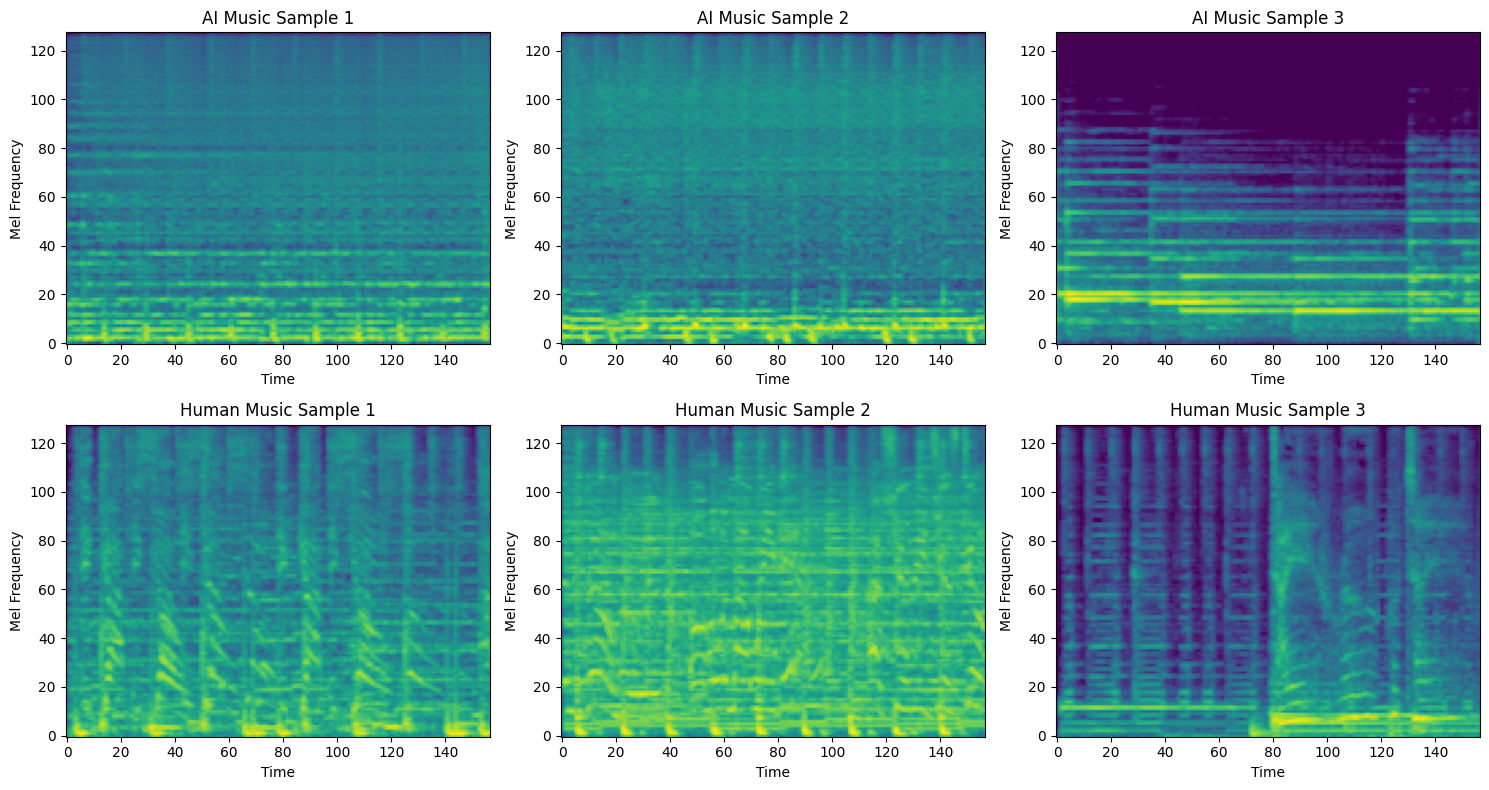

✓ Sample spectrograms saved to results/sample_spectrograms.png


In [10]:
if RUN_PHASE_1_PREPROCESSING:
    print("\n Visualizing sample spectrograms...\n")
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    # Plot 3 AI music samples
    ai_indices = np.where(labels == 1)[0][:3]
    for i, idx in enumerate(ai_indices):
        axes[0, i].imshow(spectrograms[idx], aspect='auto', origin='lower', cmap='viridis')
        axes[0, i].set_title(f'AI Music Sample {i+1}')
        axes[0, i].set_xlabel('Time')
        axes[0, i].set_ylabel('Mel Frequency')
    
    # Plot 3 Human music samples
    human_indices = np.where(labels == 0)[0][:3]
    for i, idx in enumerate(human_indices):
        axes[1, i].imshow(spectrograms[idx], aspect='auto', origin='lower', cmap='viridis')
        axes[1, i].set_title(f'Human Music Sample {i+1}')
        axes[1, i].set_xlabel('Time')
        axes[1, i].set_ylabel('Mel Frequency')
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/results/sample_spectrograms.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Sample spectrograms saved to results/sample_spectrograms.png")

### 1.9 Create Train/Val/Test Splits

In [11]:
from sklearn.model_selection import GroupShuffleSplit

if RUN_PHASE_1_PREPROCESSING:
    print("\n Creating train/validation/test splits (grouped by track_id, stratified by label)...")
    print(f"  Target ratios: {TRAIN_RATIO:.0%} train / {VAL_RATIO:.0%} val / {TEST_RATIO:.0%} test\n")

    indices = np.arange(len(spectrograms))

    def split_by_label(label_value):
        mask = (labels == label_value)
        idx = indices[mask]
        groups = track_ids[mask]

        # First: train vs temp (val+test)
        gss1 = GroupShuffleSplit(
            n_splits=1,
            test_size=(VAL_RATIO + TEST_RATIO),
            random_state=RANDOM_SEED,
        )
        train_idx_local, temp_idx_local = next(gss1.split(idx, groups=groups))

        # Now split temp into val vs test
        rel_test = TEST_RATIO / (VAL_RATIO + TEST_RATIO)
        temp_groups = groups[temp_idx_local]

        gss2 = GroupShuffleSplit(
            n_splits=1,
            test_size=rel_test,
            random_state=RANDOM_SEED + 1,
        )
        val_sub_local, test_sub_local = next(gss2.split(temp_idx_local, groups=temp_groups))

        train_global = idx[train_idx_local]
        val_global = idx[temp_idx_local[val_sub_local]]
        test_global = idx[temp_idx_local[test_sub_local]]

        return train_global, val_global, test_global

    # Split AI and human separately
    train_ai, val_ai, test_ai = split_by_label(1)
    train_h,  val_h,  test_h  = split_by_label(0)

    # Combine
    train_indices = np.concatenate([train_ai, train_h])
    val_indices   = np.concatenate([val_ai,  val_h])
    test_indices  = np.concatenate([test_ai, test_h])

    # Shuffle within each split for randomness
    rng = np.random.RandomState(RANDOM_SEED)
    rng.shuffle(train_indices)
    rng.shuffle(val_indices)
    rng.shuffle(test_indices)

    # Build final datasets
    X_train = spectrograms[train_indices]
    y_train = labels[train_indices]
    track_ids_train = track_ids[train_indices]
    sources_train = sources[train_indices]

    X_val = spectrograms[val_indices]
    y_val = labels[val_indices]
    track_ids_val = track_ids[val_indices]
    sources_val = sources[val_indices]

    X_test = spectrograms[test_indices]
    y_test = labels[test_indices]
    track_ids_test = track_ids[test_indices]
    sources_test = sources[test_indices]

    print(f"✓ Splits created:")
    print(f"  Training set:   {len(X_train)} samples ({np.sum(y_train == 1)} AI, {np.sum(y_train == 0)} Human)")
    print(f"  Validation set: {len(X_val)} samples ({np.sum(y_val == 1)} AI, {np.sum(y_val == 0)} Human)")
    print(f"  Test set:       {len(X_test)} samples ({np.sum(y_test == 1)} AI, {np.sum(y_test == 0)} Human)")

    n_total = len(spectrograms)
    print(f"\n  Sample-level ratios:")
    print(f"    Train: {len(X_train)/n_total*100:.2f}%")
    print(f"    Val:   {len(X_val)/n_total*100:.2f}%")
    print(f"    Test:  {len(X_test)/n_total*100:.2f}%")

    # Optional: run the debug cell from section 2 to see group ratios & overlaps



 Creating train/validation/test splits (grouped by track_id, stratified by label)...
  Target ratios: 70% train / 15% val / 15% test

✓ Splits created:
  Training set:   6668 samples (3869 AI, 2799 Human)
  Validation set: 1058 samples (458 AI, 600 Human)
  Test set:       1021 samples (421 AI, 600 Human)

  Sample-level ratios:
    Train: 76.23%
    Val:   12.10%
    Test:  11.67%


In [12]:
if RUN_PHASE_1_PREPROCESSING:
    n_total = len(spectrograms)

    print("\n=== SAMPLE-LEVEL RATIOS ===")
    print(f"Total samples: {n_total}")
    print(f"Train: {len(train_indices)} ({len(train_indices)/n_total*100:.2f}%)")
    print(f"Val:   {len(val_indices)}   ({len(val_indices)/n_total*100:.2f}%)")
    print(f"Test:  {len(test_indices)}  ({len(test_indices)/n_total*100:.2f}%)")

    # Group-level counts
    unique_tracks = np.unique(track_ids)
    train_tracks = np.unique(track_ids_train)
    val_tracks = np.unique(track_ids_val)
    test_tracks = np.unique(track_ids_test)

    print("\n=== GROUP-LEVEL RATIOS (by track_id) ===")
    print(f"Total tracks: {len(unique_tracks)}")
    print(f"Train tracks: {len(train_tracks)} ({len(train_tracks)/len(unique_tracks)*100:.2f}%)")
    print(f"Val tracks:   {len(val_tracks)}   ({len(val_tracks)/len(unique_tracks)*100:.2f}%)")
    print(f"Test tracks:  {len(test_tracks)}  ({len(test_tracks)/len(unique_tracks)*100:.2f}%)")

    # Overlap sanity check
    print("\n=== OVERLAP CHECK (should all be 0) ===")
    print("Train ∩ Val :", len(set(train_tracks) & set(val_tracks)))
    print("Train ∩ Test:", len(set(train_tracks) & set(test_tracks)))
    print("Val ∩ Test  :", len(set(val_tracks) & set(test_tracks)))



=== SAMPLE-LEVEL RATIOS ===
Total samples: 8747
Train: 6668 (76.23%)
Val:   1058   (12.10%)
Test:  1021  (11.67%)

=== GROUP-LEVEL RATIOS (by track_id) ===
Total tracks: 4031
Train tracks: 2821 (69.98%)
Val tracks:   605   (15.01%)
Test tracks:  605  (15.01%)

=== OVERLAP CHECK (should all be 0) ===
Train ∩ Val : 0
Train ∩ Test: 0
Val ∩ Test  : 0


### 1.10 Save Preprocessed Data

In [16]:
%%time
if RUN_PHASE_1_PREPROCESSING:
    print("\n Saving preprocessed data...")

    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Save preprocessed spectrograms + labels + metadata
    np.savez_compressed(
        f"{OUTPUT_DIR}/preprocessed_data.npz",
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        X_test=X_test,
        y_test=y_test,
        train_indices=train_indices,
        val_indices=val_indices,
        test_indices=test_indices,
        track_ids_train=track_ids_train,
        track_ids_val=track_ids_val,
        track_ids_test=track_ids_test,
        sources_train=sources_train,
        sources_val=sources_val,
        sources_test=sources_test,
    )

    # Save some human-readable metadata
    splits_metadata = {
        "num_total": int(len(labels)),
        "num_train": int(len(X_train)),
        "num_val": int(len(X_val)),
        "num_test": int(len(X_test)),
        "class_counts": {
            "train": {
                "AI": int(np.sum(y_train == 1)),
                "human": int(np.sum(y_train == 0)),
            },
            "val": {
                "AI": int(np.sum(y_val == 1)),
                "human": int(np.sum(y_val == 0)),
            },
            "test": {
                "AI": int(np.sum(y_test == 1)),
                "human": int(np.sum(y_test == 0)),
            },
        },
    }

    with open(f"{OUTPUT_DIR}/splits.json", "w") as f:
        json.dump(splits_metadata, f, indent=2)

    # Check file sizes
    data_size = os.path.getsize(f"{OUTPUT_DIR}/preprocessed_data.npz") / 1024**3
    meta_size = os.path.getsize(f"{OUTPUT_DIR}/splits.json") / 1024

    print(f"\n✓ Data saved successfully!")
    print(f"  preprocessed_data.npz: {data_size:.2f} GB")
    print(f"  splits.json:          {meta_size:.2f} KB")
    print(f"\n  Files saved to: {OUTPUT_DIR}/")

    print("\n" + "="*80)
    print(" PHASE 1 COMPLETE: Data Preprocessing")
    print("="*80)
    print(f"\n  Next: Run Phase 2A (Train Autoencoder) or Phase 2B (Extract Embeddings)")
    print(f"  Note: Phases 2A and 2B can be run in parallel by different team members")



 Saving preprocessed data...

✓ Data saved successfully!
  preprocessed_data.npz: 0.55 GB
  splits.json:          0.27 KB

  Files saved to: /kaggle/working/

 PHASE 1 COMPLETE: Data Preprocessing

  Next: Run Phase 2A (Train Autoencoder) or Phase 2B (Extract Embeddings)
  Note: Phases 2A and 2B can be run in parallel by different team members
CPU times: user 40.9 s, sys: 368 ms, total: 41.3 s
Wall time: 41.4 s


### 1.11 Load Preprocessed Data (for subsequent phases)

In [13]:
# This cell loads preprocessed data for phases 2-5
# Run this if you're restarting the notebook and skipping Phase 1

if not RUN_PHASE_1_PREPROCESSING:
    print(" Loading preprocessed data from disk...\n")

    # Import required libraries if not already imported
    import os
    import json
    import numpy as np
    import torch
    import warnings
    warnings.filterwarnings("ignore")

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load preprocessed spectrograms and labels
    data = np.load(f"{OUTPUT_DIR}/preprocessed_data.npz")

    X_train = data["X_train"]
    y_train = data["y_train"]
    X_val = data["X_val"]
    y_val = data["y_val"]
    X_test = data["X_test"]
    y_test = data["y_test"]

    train_indices = data["train_indices"]
    val_indices = data["val_indices"]
    test_indices = data["test_indices"]

    # New: track IDs and sources (for bias analysis / per-source eval)
    track_ids_train = data["track_ids_train"]
    track_ids_val = data["track_ids_val"]
    track_ids_test = data["track_ids_test"]

    sources_train = data["sources_train"]
    sources_val = data["sources_val"]
    sources_test = data["sources_test"]

    # Load metadata
    with open(f"{OUTPUT_DIR}/splits.json", "r") as f:
        splits_metadata = json.load(f)

    print(f" Preprocessed data loaded:")
    print(f"  Training set:   {len(X_train)} samples")
    print(f"  Validation set: {len(X_val)} samples")
    print(f"  Test set:       {len(X_test)} samples")
    print(f"  Spectrogram shape: {X_train.shape[1:]}")
    print(f"  Device: {device}")


---
# Phase 2A: Train Multi-Task Autoencoder (IMPROVED)
---

**Estimated Runtime**: 3-4 hours

**KEY IMPROVEMENTS**:
1. ✅ **Train on ALL music** (human + AI) instead of human-only
2. ✅ **Multi-task learning**: Reconstruction + Classification
3. ✅ **Better features**: Latents optimized for both tasks

**Tasks**:
1. Build Multi-Task Convolutional Autoencoder architecture
2. Train on ALL music with dual objectives
3. Extract 256-dim latent vectors for all samples
4. Compute reconstruction losses
5. Save best model and cached latent representations

**Outputs**:
- `checkpoints/ae_multitask_best.pth` (~500 MB)
- `embeddings/ae_latents.npz` (~200 MB)
- `embeddings/ae_losses.npz` (~50 MB)

**Note**: This phase can run in parallel with Phase 2B

### 2A.1 Define Multi-Task Autoencoder Architecture (IMPROVED)

In [14]:
if RUN_PHASE_2A_TRAIN_AE:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    
    class MultiTaskAutoencoder(nn.Module):
        """
        Multi-Task Autoencoder with dual objectives:
        1. Reconstruction loss (learn general music features)
        2. Classification loss (learn discriminative features)
        
        This creates latent representations optimized for BOTH tasks!
        
        Architecture:
        - Encoder: 4 conv layers with batch norm and max pooling
        - Latent: 256-dimensional bottleneck
        - Decoder: 4 transposed conv layers (for reconstruction)
        - Classifier: MLP head (for AI vs Human classification)
        
        Input: Mel-spectrogram (1, 128, time_steps)
        Output: Reconstructed spectrogram + Classification logits + 256-dim latent
        """
        
        def __init__(self, latent_dim=AE_LATENT_DIM, input_channels=1, input_height=128, input_width=157):
            super(MultiTaskAutoencoder, self).__init__()
            
            self.latent_dim = latent_dim
            self.input_height = input_height
            self.input_width = input_width
            
            # =====================================================================
            # Encoder (shared for both tasks)
            # =====================================================================
            self.encoder = nn.Sequential(
                # Layer 1: (1, 128, T) -> (32, 64, T/2)
                nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                
                # Layer 2: (32, 64, T/2) -> (64, 32, T/4)
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                
                # Layer 3: (64, 32, T/4) -> (128, 16, T/8)
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                
                # Layer 4: (128, 16, T/8) -> (256, 8, T/16)
                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )
            
            # Calculate encoder output size
            dummy_input = torch.zeros(1, input_channels, input_height, input_width)
            with torch.no_grad():
                dummy_output = self.encoder(dummy_input)
                self.encoder_output_size = dummy_output.view(1, -1).size(1)
                self.encoder_output_shape = dummy_output.shape[1:]
            
            # =====================================================================
            # Latent space bottleneck
            # =====================================================================
            self.fc_encode = nn.Linear(self.encoder_output_size, latent_dim)
            self.fc_decode = nn.Linear(latent_dim, self.encoder_output_size)
            
            # =====================================================================
            # Decoder (for reconstruction task)
            # =====================================================================
            self.decoder = nn.Sequential(
                # Layer 1: (256, 8, T/16) -> (128, 16, T/8)
                nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                
                # Layer 2: (128, 16, T/8) -> (64, 32, T/4)
                nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                
                # Layer 3: (64, 32, T/4) -> (32, 64, T/2)
                nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                
                # Layer 4: (32, 64, T/2) -> (1, 128, T)
                nn.ConvTranspose2d(32, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.Tanh()
            )
            
            self.adaptive_pool = nn.AdaptiveAvgPool2d((input_height, input_width))
            
            # =====================================================================
            # Classification head (for AI vs Human task)
            # =====================================================================
            self.classifier = nn.Sequential(
                nn.Linear(latent_dim, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                
                nn.Linear(128, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                
                nn.Linear(64, 2)  # Binary classification
            )
        
        def encode(self, x):
            """Encode input to latent representation."""
            x = self.encoder(x)
            x = x.view(x.size(0), -1)
            latent = self.fc_encode(x)
            return latent
        
        def decode(self, latent):
            """Decode latent representation to reconstruction."""
            x = self.fc_decode(latent)
            x = x.view(x.size(0), *self.encoder_output_shape)
            x = self.decoder(x)
            x = self.adaptive_pool(x)
            return x
        
        def classify(self, latent):
            """Classify from latent representation."""
            return self.classifier(latent)
        
        def forward(self, x):
            """
            Forward pass with dual outputs.
            Returns: (reconstruction, class_logits, latent)
            """
            latent = self.encode(x)
            reconstruction = self.decode(latent)
            class_logits = self.classify(latent)
            return reconstruction, class_logits, latent
    
    print("✓ Multi-Task Autoencoder architecture defined")
    print(f"  Latent dimension: {AE_LATENT_DIM}")
    print(f"  Tasks: Reconstruction + Classification")
    print(f"  Benefits:")
    print(f"  Learns general music features (reconstruction)")
    print(f"  Learns discriminative features (classification)")
    print(f"  Better latent representations for downstream tasks")
else:
    print("⏭ Skipping Phase 2A: Train Autoencoder")

✓ Multi-Task Autoencoder architecture defined
  Latent dimension: 256
  Tasks: Reconstruction + Classification
  Benefits:
  Learns general music features (reconstruction)
  Learns discriminative features (classification)
  Better latent representations for downstream tasks


### 2A.2 Create Dataset for Autoencoder Training

In [15]:
if RUN_PHASE_2A_TRAIN_AE:
    from torch.utils.data import Dataset, DataLoader
    
    class SpectrogramDataset(Dataset):
        """PyTorch Dataset for mel-spectrograms with labels."""
        
        def __init__(self, spectrograms, labels=None, transform=None):
            """
            Args:
                spectrograms: numpy array of shape (N, n_mels, time_steps)
                labels: numpy array of shape (N,) with class labels (0=Human, 1=AI)
                transform: optional transforms
            """
            self.spectrograms = spectrograms
            self.labels = labels
            self.transform = transform
        
        def __len__(self):
            return len(self.spectrograms)
        
        def __getitem__(self, idx):
            # Get spectrogram and add channel dimension
            spec = self.spectrograms[idx]
            spec = spec[np.newaxis, :, :]  # (n_mels, time) -> (1, n_mels, time)
            
            # Convert to tensor
            spec = torch.from_numpy(spec).float()
            
            # Normalize to [-1, 1]
            spec = (spec - spec.min()) / (spec.max() - spec.min() + 1e-8)
            spec = 2 * spec - 1
            
            if self.labels is not None:
                label = self.labels[idx]
                return spec, label
            else:
                return spec
    
    # =========================================================================
    # IMPROVEMENT: Train on ALL music (Human + AI), not just human-only!
    # =========================================================================
    print(f"\n IMPROVED: Training autoencoder on ALL music (human + AI)")
    print(f"  Old approach: Train only on human music")
    print(f"  New approach: Train on both classes")
    print(f"  Benefits:")
    print(f"   Learns general music features (not biased to human-only)")
    print(f"   Better reconstruction for both classes")
    print(f"   More discriminative latent space\n")
    
    # Use ALL training data (not filtered by class)
    print(f" Autoencoder training data (ALL music):")
    print(f"  Training samples: {len(X_train)} ({np.sum(y_train == 1)} AI, {np.sum(y_train == 0)} Human)")
    print(f"  Validation samples: {len(X_val)} ({np.sum(y_val == 1)} AI, {np.sum(y_val == 0)} Human)")
    
    # Create datasets with labels
    train_dataset_ae = SpectrogramDataset(X_train, y_train)
    val_dataset_ae = SpectrogramDataset(X_val, y_val)
    
    # Create dataloaders
    train_loader_ae = DataLoader(
        train_dataset_ae,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    val_loader_ae = DataLoader(
        val_dataset_ae,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    print(f"  Training batches: {len(train_loader_ae)}")
    print(f"  Validation batches: {len(val_loader_ae)}")
    print(f"  Batch size: {BATCH_SIZE}")


 IMPROVED: Training autoencoder on ALL music (human + AI)
  Old approach: Train only on human music
  New approach: Train on both classes
  Benefits:
   Learns general music features (not biased to human-only)
   Better reconstruction for both classes
   More discriminative latent space

 Autoencoder training data (ALL music):
  Training samples: 6668 (3869 AI, 2799 Human)
  Validation samples: 1058 (458 AI, 600 Human)
  Training batches: 209
  Validation batches: 34
  Batch size: 32


### 2A.3 Multi-Task Training Functions (IMPROVED)

In [16]:
if RUN_PHASE_2A_TRAIN_AE:
    import time
    from tqdm.auto import tqdm
    
    def train_multitask_ae_epoch(model, dataloader, recon_criterion, class_criterion, optimizer, device, recon_weight=1.0, class_weight=0.5):
        """
        Train multi-task autoencoder for one epoch.
        
        Args:
            recon_weight: Weight for reconstruction loss
            class_weight: Weight for classification loss
        """
        model.train()
        total_recon_loss = 0
        total_class_loss = 0
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (data, labels) in enumerate(tqdm(dataloader, desc="Training", leave=False)):
            data, labels = data.to(device), labels.to(device)
            
            # Forward pass
            reconstruction, class_logits, latent = model(data)
            
            # Compute losses
            recon_loss = recon_criterion(reconstruction, data)
            class_loss = class_criterion(class_logits, labels)
            
            # Combined loss with weighting
            loss = recon_weight * recon_loss + class_weight * class_loss
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track metrics
            total_recon_loss += recon_loss.item()
            total_class_loss += class_loss.item()
            total_loss += loss.item()
            
            # Classification accuracy
            _, predicted = torch.max(class_logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        avg_recon_loss = total_recon_loss / len(dataloader)
        avg_class_loss = total_class_loss / len(dataloader)
        avg_total_loss = total_loss / len(dataloader)
        accuracy = 100 * correct / total
        
        return avg_recon_loss, avg_class_loss, avg_total_loss, accuracy
    
    def validate_multitask_ae(model, dataloader, recon_criterion, class_criterion, device, recon_weight=1.0, class_weight=0.5):
        """Validate multi-task autoencoder."""
        model.eval()
        total_recon_loss = 0
        total_class_loss = 0
        total_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, labels in tqdm(dataloader, desc="Validating", leave=False):
                data, labels = data.to(device), labels.to(device)
                
                # Forward pass
                reconstruction, class_logits, latent = model(data)
                
                # Compute losses
                recon_loss = recon_criterion(reconstruction, data)
                class_loss = class_criterion(class_logits, labels)
                loss = recon_weight * recon_loss + class_weight * class_loss
                
                total_recon_loss += recon_loss.item()
                total_class_loss += class_loss.item()
                total_loss += loss.item()
                
                # Classification accuracy
                _, predicted = torch.max(class_logits.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_recon_loss = total_recon_loss / len(dataloader)
        avg_class_loss = total_class_loss / len(dataloader)
        avg_total_loss = total_loss / len(dataloader)
        accuracy = 100 * correct / total
        
        return avg_recon_loss, avg_class_loss, avg_total_loss, accuracy
    
    def save_checkpoint(model, optimizer, epoch, loss, filepath, is_best=False):
        """Save model checkpoint."""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
        }
        torch.save(checkpoint, filepath)
        if is_best:
            print(f"  Saved best model: {filepath}")
    
    print("✓ Multi-task training functions defined")
    print("  Optimizes for:")
    print("    1. Reconstruction loss (MSE)")
    print("    2. Classification loss (Cross-Entropy)")
    print("  Combined loss = recon_loss + 0.5 * class_loss")

✓ Multi-task training functions defined
  Optimizes for:
    1. Reconstruction loss (MSE)
    2. Classification loss (Cross-Entropy)
  Combined loss = recon_loss + 0.5 * class_loss


### 2A.4 Train Multi-Task Autoencoder (IMPROVED)


 Starting Multi-Task Autoencoder Training...
  Device: cuda
  Epochs: 50
  Learning Rate: 0.0001
  Early Stopping Patience: 5
  Reconstruction Weight: 1.0
  Classification Weight: 0.5



Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [1/50]
  Train - Recon: 0.099374, Class: 0.332122, Total: 0.265435, Acc: 88.02%
  Val   - Recon: 0.064101, Class: 0.363375, Total: 0.245788, Acc: 81.76%
  Time: 10.0s
  Saved best model: /kaggle/working/checkpoints/ae_multitask_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [2/50]
  Train - Recon: 0.058076, Class: 0.150733, Total: 0.133443, Acc: 96.57%
  Val   - Recon: 0.053470, Class: 0.210292, Total: 0.158616, Acc: 93.01%
  Time: 9.6s
  Saved best model: /kaggle/working/checkpoints/ae_multitask_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [3/50]
  Train - Recon: 0.052821, Class: 0.098889, Total: 0.102265, Acc: 97.74%
  Val   - Recon: 0.050108, Class: 0.254729, Total: 0.177472, Acc: 91.30%
  Time: 9.7s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [4/50]
  Train - Recon: 0.050150, Class: 0.065106, Total: 0.082703, Acc: 98.65%
  Val   - Recon: 0.047958, Class: 0.229345, Total: 0.162631, Acc: 91.68%
  Time: 9.7s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [5/50]
  Train - Recon: 0.048492, Class: 0.050414, Total: 0.073699, Acc: 98.76%
  Val   - Recon: 0.048871, Class: 0.286893, Total: 0.192318, Acc: 89.51%
  Time: 9.8s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [6/50]
  Train - Recon: 0.047072, Class: 0.034172, Total: 0.064157, Acc: 99.33%
  Val   - Recon: 0.045581, Class: 0.267851, Total: 0.179507, Acc: 90.17%
  Time: 9.9s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [7/50]
  Train - Recon: 0.046087, Class: 0.034099, Total: 0.063137, Acc: 99.10%
  Val   - Recon: 0.044504, Class: 0.299007, Total: 0.194008, Acc: 90.36%
  Time: 10.0s

⏸ Early stopping triggered after 7 epochs

✓ Training complete!
  Total time: 1.2 minutes
  Best validation total loss: 0.158616
  Model saved to: checkpoints/ae_multitask_best.pth


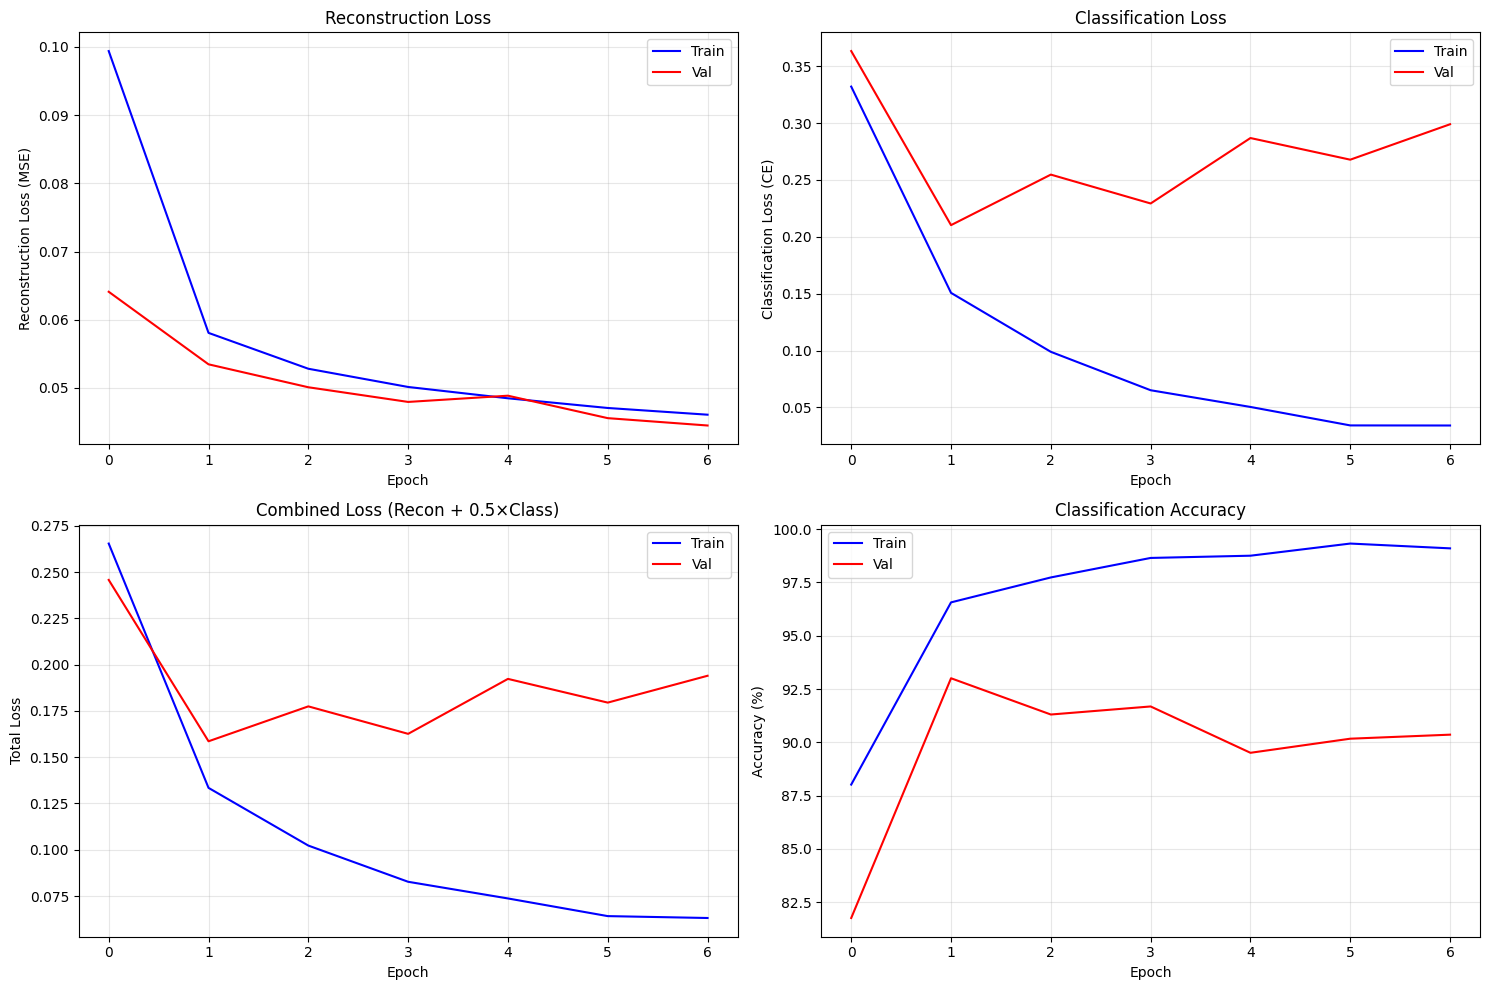


✓ Training curves saved to results/ae_multitask_training.png
CPU times: user 1min 37s, sys: 1.84 s, total: 1min 39s
Wall time: 1min 13s


In [17]:
%%time
if RUN_PHASE_2A_TRAIN_AE:
    print("\n Starting Multi-Task Autoencoder Training...")
    print(f"  Device: {device}")
    print(f"  Epochs: {NUM_EPOCHS_AE}")
    print(f"  Learning Rate: {LEARNING_RATE}")
    print(f"  Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")
    print(f"  Reconstruction Weight: 1.0")
    print(f"  Classification Weight: 0.5\n")
    
    # Initialize multi-task model
    model_ae = MultiTaskAutoencoder(latent_dim=AE_LATENT_DIM).to(device)
    
    # Loss functions
    recon_criterion = nn.MSELoss()
    class_criterion = nn.CrossEntropyLoss()
    
    # Optimizer
    optimizer = torch.optim.Adam(model_ae.parameters(), lr=LEARNING_RATE)
    
    # Training tracking
    train_recon_losses = []
    train_class_losses = []
    train_total_losses = []
    train_accuracies = []
    
    val_recon_losses = []
    val_class_losses = []
    val_total_losses = []
    val_accuracies = []
    
    best_val_total_loss = float('inf')
    patience_counter = 0
    
    # Training loop
    start_time = time.time()
    
    for epoch in range(NUM_EPOCHS_AE):
        epoch_start = time.time()
        
        # Train
        train_recon, train_class, train_total, train_acc = train_multitask_ae_epoch(
            model_ae, train_loader_ae, recon_criterion, class_criterion, optimizer, device
        )
        train_recon_losses.append(train_recon)
        train_class_losses.append(train_class)
        train_total_losses.append(train_total)
        train_accuracies.append(train_acc)
        
        # Validate
        val_recon, val_class, val_total, val_acc = validate_multitask_ae(
            model_ae, val_loader_ae, recon_criterion, class_criterion, device
        )
        val_recon_losses.append(val_recon)
        val_class_losses.append(val_class)
        val_total_losses.append(val_total)
        val_accuracies.append(val_acc)
        
        epoch_time = time.time() - epoch_start
        
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS_AE}]")
        print(f"  Train - Recon: {train_recon:.6f}, Class: {train_class:.6f}, Total: {train_total:.6f}, Acc: {train_acc:.2f}%")
        print(f"  Val   - Recon: {val_recon:.6f}, Class: {val_class:.6f}, Total: {val_total:.6f}, Acc: {val_acc:.2f}%")
        print(f"  Time: {epoch_time:.1f}s")
        
        # Save last checkpoint
        save_checkpoint(
            model_ae, optimizer, epoch, val_total,
            f"{OUTPUT_DIR}/checkpoints/ae_multitask_last.pth"
        )
        
        # Check if best model
        if val_total < best_val_total_loss:
            best_val_total_loss = val_total
            patience_counter = 0
            save_checkpoint(
                model_ae, optimizer, epoch, val_total,
                f"{OUTPUT_DIR}/checkpoints/ae_multitask_best.pth",
                is_best=True
            )
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\n⏸ Early stopping triggered after {epoch+1} epochs")
            break
    
    total_time = time.time() - start_time
    
    print(f"\n✓ Training complete!")
    print(f"  Total time: {total_time/60:.1f} minutes")
    print(f"  Best validation total loss: {best_val_total_loss:.6f}")
    print(f"  Model saved to: checkpoints/ae_multitask_best.pth")
    
    # Plot training curves
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Reconstruction loss
    axes[0, 0].plot(train_recon_losses, label='Train', color='blue')
    axes[0, 0].plot(val_recon_losses, label='Val', color='red')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Reconstruction Loss (MSE)')
    axes[0, 0].set_title('Reconstruction Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Classification loss
    axes[0, 1].plot(train_class_losses, label='Train', color='blue')
    axes[0, 1].plot(val_class_losses, label='Val', color='red')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Classification Loss (CE)')
    axes[0, 1].set_title('Classification Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Total loss
    axes[1, 0].plot(train_total_losses, label='Train', color='blue')
    axes[1, 0].plot(val_total_losses, label='Val', color='red')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Total Loss')
    axes[1, 0].set_title('Combined Loss (Recon + 0.5×Class)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Classification accuracy
    axes[1, 1].plot(train_accuracies, label='Train', color='blue')
    axes[1, 1].plot(val_accuracies, label='Val', color='red')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].set_title('Classification Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/results/ae_multitask_training.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Training curves saved to results/ae_multitask_training.png")

### 2A.5 Extract Latent Vectors for All Samples


Extracting latent vectors and reconstruction losses for all samples...

  Processing training set...


Extracting:   0%|          | 0/209 [00:00<?, ?it/s]

  Processing validation set...


Extracting:   0%|          | 0/34 [00:00<?, ?it/s]

  Processing test set...


Extracting:   0%|          | 0/32 [00:00<?, ?it/s]


✓ Extraction complete!
  Train latents: (6668, 256)
  Val latents: (1058, 256)
  Test latents: (1021, 256)

  Saved to embeddings/:
    ae_latents.npz: 7.9 MB
    ae_losses.npz: 0.0 MB

  Reconstruction Loss Statistics:
    Train - Mean: 0.053107, Std: 0.022076
    Train - Human mean: 0.047782
    Train - AI mean: 0.056960


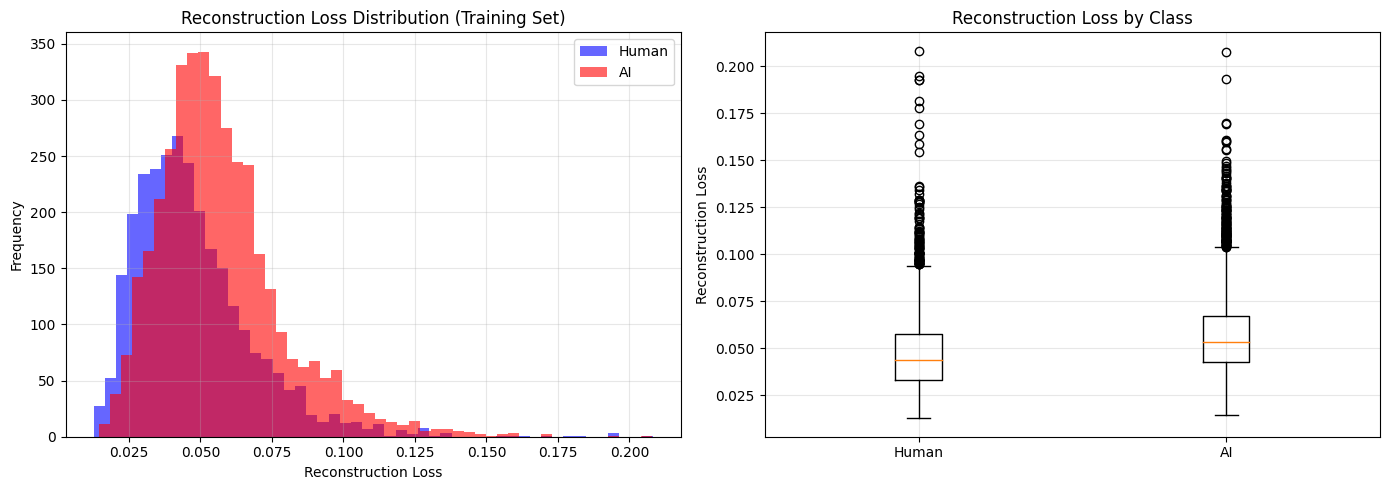


PHASE 2A COMPLETE: Multi-Task Autoencoder Training

  Outputs:
    - checkpoints/ae_multitask_best.pth
    - embeddings/ae_latents.npz
    - embeddings/ae_losses.npz
    - results/ae_multitask_training.png
    - results/ae_reconstruction_losses.png

  Next: Run Phase 2B (Extract Transformer Embeddings) or continue to Phase 3
CPU times: user 6.61 s, sys: 101 ms, total: 6.71 s
Wall time: 6.68 s


In [18]:
%%time
if RUN_PHASE_2A_TRAIN_AE:
    print("\nExtracting latent vectors and reconstruction losses for all samples...")
    
    # Load best model
    checkpoint = torch.load(f"{OUTPUT_DIR}/checkpoints/ae_multitask_best.pth")
    model_ae.load_state_dict(checkpoint['model_state_dict'])
    model_ae.eval()
    
    def extract_latents_and_losses(model, spectrograms, batch_size=BATCH_SIZE):
        """Extract latent vectors and reconstruction losses from multi-task model."""
        dataset = SpectrogramDataset(spectrograms)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        all_latents = []
        all_losses = []
        
        with torch.no_grad():
            for data in tqdm(dataloader, desc="Extracting"):
                data = data.to(device)
                
                # Get reconstruction, class_logits, and latent (multi-task model returns 3 values)
                reconstruction, _, latent = model(data)
                
                # Compute reconstruction loss per sample
                losses = F.mse_loss(reconstruction, data, reduction='none')
                losses = losses.view(data.size(0), -1).mean(dim=1)  # Average per sample
                
                all_latents.append(latent.cpu().numpy())
                all_losses.append(losses.cpu().numpy())
        
        latents = np.concatenate(all_latents, axis=0)
        losses = np.concatenate(all_losses, axis=0)
        
        return latents, losses
    
    # Extract for train set
    print("\n  Processing training set...")
    train_latents, train_losses = extract_latents_and_losses(model_ae, X_train)
    
    # Extract for validation set
    print("  Processing validation set...")
    val_latents, val_losses = extract_latents_and_losses(model_ae, X_val)
    
    # Extract for test set
    print("  Processing test set...")
    test_latents, test_losses = extract_latents_and_losses(model_ae, X_test)
    
    print(f"\n✓ Extraction complete!")
    print(f"  Train latents: {train_latents.shape}")
    print(f"  Val latents: {val_latents.shape}")
    print(f"  Test latents: {test_latents.shape}")
    
    # Save latent vectors
    np.savez_compressed(
        f"{OUTPUT_DIR}/embeddings/ae_latents.npz",
        train_latents=train_latents,
        val_latents=val_latents,
        test_latents=test_latents
    )
    
    # Save reconstruction losses
    np.savez_compressed(
        f"{OUTPUT_DIR}/embeddings/ae_losses.npz",
        train_losses=train_losses,
        val_losses=val_losses,
        test_losses=test_losses
    )
    
    # Check file sizes
    latents_size = os.path.getsize(f"{OUTPUT_DIR}/embeddings/ae_latents.npz") / 1024**2
    losses_size = os.path.getsize(f"{OUTPUT_DIR}/embeddings/ae_losses.npz") / 1024**2
    
    print(f"\n  Saved to embeddings/:")
    print(f"    ae_latents.npz: {latents_size:.1f} MB")
    print(f"    ae_losses.npz: {losses_size:.1f} MB")
    
    # Analyze reconstruction loss distribution
    print(f"\n  Reconstruction Loss Statistics:")
    print(f"    Train - Mean: {train_losses.mean():.6f}, Std: {train_losses.std():.6f}")
    print(f"    Train - Human mean: {train_losses[y_train==0].mean():.6f}")
    print(f"    Train - AI mean: {train_losses[y_train==1].mean():.6f}")
    
    # Plot loss distributions
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Loss distribution by class
    axes[0].hist(train_losses[y_train==0], bins=50, alpha=0.6, label='Human', color='blue')
    axes[0].hist(train_losses[y_train==1], bins=50, alpha=0.6, label='AI', color='red')
    axes[0].set_xlabel('Reconstruction Loss')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Reconstruction Loss Distribution (Training Set)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Box plot
    loss_data = [train_losses[y_train==0], train_losses[y_train==1]]
    axes[1].boxplot(loss_data, labels=['Human', 'AI'])
    axes[1].set_ylabel('Reconstruction Loss')
    axes[1].set_title('Reconstruction Loss by Class')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/results/ae_reconstruction_losses.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*80)
    print("PHASE 2A COMPLETE: Multi-Task Autoencoder Training")
    print("="*80)
    print(f"\n  Outputs:")
    print(f"    - checkpoints/ae_multitask_best.pth")
    print(f"    - embeddings/ae_latents.npz")
    print(f"    - embeddings/ae_losses.npz")
    print(f"    - results/ae_multitask_training.png")
    print(f"    - results/ae_reconstruction_losses.png")
    print(f"\n  Next: Run Phase 2B (Extract Transformer Embeddings) or continue to Phase 3")

---
# Phase 2B: Train AST Transformer & Extract Embeddings (REAL TRANSFORMER)
---

**Estimated Runtime**: 3-4 hours

**Tasks**:
1. Load pre-trained Audio Spectrogram Transformer (AST) from MIT
2. **[REAL TRANSFORMER]** Uses 12 transformer blocks with self-attention on spectrogram patches
3. Fine-tune on AI/Human classification task (or use frozen features)
4. Extract 512-dim semantic embeddings for all samples
5. Save cached embeddings

**Outputs**:
- `checkpoints/transformer_encoder_best.pth` (~300 MB with AST)
- `embeddings/transformer_embeddings.npz` (~200 MB)

**Key Difference**: This is a REAL vision transformer (ViT) adapted for audio, not a CNN!
**Pre-training**: AudioSet with 10M+ audio samples and 527 event classes

### 2B.1 Load Pre-trained Audio Spectrogram Transformer (AST)

In [19]:
if RUN_PHASE_2B_EXTRACT_EMBEDDINGS:
    # Workaround: Disable torchaudio compliance check for AST import
    import os
    os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true'
    
    # Import AST model (bypassing torchaudio feature extractor)
    try:
        print("\n🔧 Setting up REAL Audio Spectrogram Transformer (AST)...")
        print("  Attempting to load from HuggingFace...\n")
        
        # Import just the model, not the feature extractor (which needs torchaudio)
        from transformers import ASTModel
        from transformers import logging as hf_logging
        hf_logging.set_verbosity_error()  # Suppress warnings
        
        print("  ✓ AST import successful!")
        AST_AVAILABLE = True
    except Exception as e:
        print(f"\n Warning: Could not import AST model")
        print(f"  Error type: {type(e).__name__}")
        print(f"  Error message: {str(e)[:200]}")
        print("\n  Troubleshooting steps:")
        print("  1. RESTART THE KERNEL after running cell 1.1 (Install Dependencies)")
        print("  2. Check versions by running in a new cell:")
        print("     !pip list | grep -E 'torch|transformers'")
        print("  3. Expected versions:")
        print("     - torch: 2.1.0+cu118")
        print("     - torchaudio: 2.1.0+cu118")
        print("     - transformers: latest")
        print("\n  Falling back to CNN-based encoder for now...")
        AST_AVAILABLE = False
    
    class ASTTransformerEncoder(nn.Module):
        """
        Audio Spectrogram Transformer (AST) from MIT.
        
        Architecture:
        - Vision Transformer (ViT) adapted for audio spectrograms
        - 12 transformer blocks with multi-head self-attention
        - Pre-trained on AudioSet (10M+ audio samples, 527 classes)
        - Processes spectrogram as sequence of patches
        
        Reference: https://arxiv.org/abs/2104.01778
        """
        def __init__(self, embedding_dim=512, num_classes=2, freeze_backbone=False):
            super(ASTTransformerEncoder, self).__init__()
            
            if AST_AVAILABLE:
                # Load pre-trained AST model from MIT
                # This model was trained on AudioSet-2M with 527 audio event classes
                print("  Downloading AST model (this may take a moment)...")
                self.ast = ASTModel.from_pretrained(
                    "MIT/ast-finetuned-audioset-10-10-0.4593"
                )
                print("  ✓ AST model loaded successfully")
                
                # Optionally freeze backbone (recommended for efficiency)
                self.freeze_backbone = freeze_backbone
                if freeze_backbone:
                    for param in self.ast.parameters():
                        param.requires_grad = False
                    print("  ✓ AST backbone frozen (only training projection + classifier)")
                else:
                    print(" AST backbone trainable (will be fine-tuned)")
                
                # AST outputs 768-dim embeddings, project to desired dimension
                self.projection = nn.Sequential(
                    nn.Linear(768, embedding_dim),
                    nn.LayerNorm(embedding_dim)
                )
                self.use_ast = True
            else:
                # Fallback: CNN-based encoder
                print("  Using CNN-based encoder as fallback")
                self.encoder = nn.Sequential(
                    nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    
                    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    
                    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    
                    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(512),
                    nn.ReLU(inplace=True),
                    nn.AdaptiveAvgPool2d((1, 1))
                )
                
                self.projection = nn.Sequential(
                    nn.Linear(512, embedding_dim),
                    nn.LayerNorm(embedding_dim)
                )
                self.use_ast = False
            
            # Classification head for training
            self.classifier = nn.Sequential(
                nn.Linear(embedding_dim, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                nn.Linear(256, num_classes)
            )
        
        def forward(self, x, return_embedding=False):
            """
            Args:
                x: tensor of shape (B, 1, 128, T) - Mel-spectrogram
                return_embedding: if True, returns embeddings; if False, returns class logits
            
            Returns:
                If return_embedding=True: embeddings of shape (B, embedding_dim)
                If return_embedding=False: logits of shape (B, num_classes)
            """
            B, C, H, W = x.shape
            
            if self.use_ast:
                # AST expects input of shape (B, 128, 1024)
                # If time dimension doesn't match, interpolate
                if W != 1024:
                    x = F.interpolate(x, size=(128, 1024), mode='bilinear', align_corners=False)
                
                # Remove channel dimension: (B, 1, 128, 1024) -> (B, 128, 1024)
                x = x.squeeze(1)
                
                # Pass through AST transformer
                outputs = self.ast(x)
                
                # Extract [CLS] token embedding
                cls_embedding = outputs.last_hidden_state[:, 0]  # (B, 768)
                
                # Project to desired embedding dimension
                embedding = self.projection(cls_embedding)  # (B, embedding_dim)
            else:
                # CNN fallback
                x = self.encoder(x)
                x = x.view(x.size(0), -1)  # Flatten
                embedding = self.projection(x)
            
            if return_embedding:
                return embedding
            else:
                logits = self.classifier(embedding)
                return logits
    
    # Initialize the encoder
    transformer_encoder = ASTTransformerEncoder(
        embedding_dim=TRANSFORMER_DIM,
        num_classes=2,
        freeze_backbone=True  # Set to False for fine-tuning (slower but potentially better)
    ).to(device)
    
    if AST_AVAILABLE:
        print("\n✓ REAL Audio Spectrogram Transformer initialized!")
        print(f"  Model device: {device}")
        print(f"  Architecture: Vision Transformer (ViT) for Audio")
        print(f"  Pre-training: AudioSet (10M samples, 527 classes)")
        print(f"  Transformer blocks: 12")
        print(f"  Self-attention heads: 12 per block")
        print(f"  Hidden dimension: 768")
        print(f"  Output embedding dimension: {TRANSFORMER_DIM}")
    else:
        print("\n✓ CNN-based encoder initialized (AST fallback)")
        print(f"  Model device: {device}")
        print(f"  Output embedding dimension: {TRANSFORMER_DIM}")
        print("\n  To use real AST:")
        print("  1. Go to Runtime → Restart runtime")
        print("  2. Re-run cells 1.1, 1.2, then this cell (2B.1)")
    
    print(f"  Trainable parameters: {sum(p.numel() for p in transformer_encoder.parameters() if p.requires_grad):,}")
    print(f"  Total parameters: {sum(p.numel() for p in transformer_encoder.parameters()):,}")

else:
    print("  Skipping Phase 2B: Transformer Encoder Training & Extraction")


🔧 Setting up REAL Audio Spectrogram Transformer (AST)...
  Attempting to load from HuggingFace...

  ✓ AST import successful!
  ✓ AST model loaded successfully
  ✓ AST backbone frozen (only training projection + classifier)

✓ REAL Audio Spectrogram Transformer initialized!
  Model device: cuda
  Architecture: Vision Transformer (ViT) for Audio
  Pre-training: AudioSet (10M samples, 527 classes)
  Transformer blocks: 12
  Self-attention heads: 12 per block
  Hidden dimension: 768
  Output embedding dimension: 512
  Trainable parameters: 526,594
  Total parameters: 86,713,858


### 2B.2 Train Transformer Encoder (IMPROVED)

In [20]:
%%time
if RUN_PHASE_2B_EXTRACT_EMBEDDINGS:
    print("\n Training Transformer Encoder as Classifier...")
    print(f"  Device: {device}")
    print(f"  Epochs: {NUM_EPOCHS_CLASSIFIER}")
    print(f"  Learning Rate: {LEARNING_RATE}")
    print(f"  Early Stopping Patience: {EARLY_STOPPING_PATIENCE}\n")
    
    # Create dataloaders (reuse the same train/val data)
    train_dataset_te = SpectrogramDataset(X_train, y_train)
    val_dataset_te = SpectrogramDataset(X_val, y_val)
    
    train_loader_te = DataLoader(train_dataset_te, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader_te = DataLoader(val_dataset_te, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(transformer_encoder.parameters(), lr=LEARNING_RATE)
    
    # Training tracking
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_acc = 0.0
    patience_counter = 0
    
    # Training functions
    def train_encoder_epoch(model, dataloader, criterion, optimizer, device):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for spectrograms, labels in tqdm(dataloader, desc="Training", leave=False):
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass (get logits, not embeddings)
            logits = model(spectrograms, return_embedding=False)
            loss = criterion(logits, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Track metrics
            running_loss += loss.item() * spectrograms.size(0)
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        avg_loss = running_loss / total
        accuracy = 100.0 * correct / total
        
        return avg_loss, accuracy
    
    def validate_encoder(model, dataloader, criterion, device):
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for spectrograms, labels in tqdm(dataloader, desc="Validating", leave=False):
                spectrograms = spectrograms.to(device)
                labels = labels.to(device)
                
                # Forward pass
                logits = model(spectrograms, return_embedding=False)
                loss = criterion(logits, labels)
                
                # Track metrics
                running_loss += loss.item() * spectrograms.size(0)
                _, predicted = torch.max(logits, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_loss = running_loss / total
        accuracy = 100.0 * correct / total
        
        return avg_loss, accuracy
    
    # Training loop
    start_time = time.time()
    
    for epoch in range(NUM_EPOCHS_CLASSIFIER):
        epoch_start = time.time()
        
        # Train
        train_loss, train_acc = train_encoder_epoch(
            transformer_encoder, train_loader_te, criterion, optimizer, device
        )
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Validate
        val_loss, val_acc = validate_encoder(
            transformer_encoder, val_loader_te, criterion, device
        )
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        epoch_time = time.time() - epoch_start
        
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS_CLASSIFIER}]")
        print(f"  Train - Loss: {train_loss:.6f}, Acc: {train_acc:.2f}%")
        print(f"  Val   - Loss: {val_loss:.6f}, Acc: {val_acc:.2f}%")
        print(f"  Time: {epoch_time:.1f}s")
        
        # Save last checkpoint
        save_checkpoint(
            transformer_encoder, optimizer, epoch, val_loss,
            f"{OUTPUT_DIR}/checkpoints/transformer_encoder_last.pth"
        )
        
        # Check if best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            save_checkpoint(
                transformer_encoder, optimizer, epoch, val_loss,
                f"{OUTPUT_DIR}/checkpoints/transformer_encoder_best.pth",
                is_best=True
            )
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\n⏸ Early stopping triggered after {epoch+1} epochs")
            break
    
    total_time = time.time() - start_time
    
    print(f"\n✓ Training complete!")
    print(f"  Total time: {total_time/60:.1f} minutes")
    print(f"  Best validation accuracy: {best_val_acc:.2f}%")
    print(f"  Model saved to: checkpoints/transformer_encoder_best.pth")
    
    # Plot training curves
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Loss
    axes[0].plot(train_losses, label='Train', color='blue')
    axes[0].plot(val_losses, label='Val', color='red')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Transformer Encoder Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Accuracy
    axes[1].plot(train_accuracies, label='Train', color='blue')
    axes[1].plot(val_accuracies, label='Val', color='red')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Transformer Encoder Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/results/transformer_encoder_training.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Training curves saved to results/transformer_encoder_training.png")
    
    # Load best model for embedding extraction
    print("\n Loading best model for embedding extraction...")
    checkpoint = torch.load(f"{OUTPUT_DIR}/checkpoints/transformer_encoder_best.pth")
    transformer_encoder.load_state_dict(checkpoint['model_state_dict'])
    transformer_encoder.eval()
    print("✓ Best model loaded")


 Training Transformer Encoder as Classifier...
  Device: cuda
  Epochs: 30
  Learning Rate: 0.0001
  Early Stopping Patience: 5



Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [1/30]
  Train - Loss: 0.487293, Acc: 76.65%
  Val   - Loss: 0.558068, Acc: 74.48%
  Time: 732.2s
  Saved best model: /kaggle/working/checkpoints/transformer_encoder_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [2/30]
  Train - Loss: 0.384449, Acc: 82.93%
  Val   - Loss: 0.520925, Acc: 74.20%
  Time: 733.3s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [3/30]
  Train - Loss: 0.341205, Acc: 85.15%
  Val   - Loss: 0.520993, Acc: 77.22%
  Time: 734.2s
  Saved best model: /kaggle/working/checkpoints/transformer_encoder_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [4/30]
  Train - Loss: 0.321720, Acc: 85.90%
  Val   - Loss: 0.459650, Acc: 79.21%
  Time: 735.2s
  Saved best model: /kaggle/working/checkpoints/transformer_encoder_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [5/30]
  Train - Loss: 0.299514, Acc: 87.25%
  Val   - Loss: 0.453774, Acc: 79.11%
  Time: 733.1s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [6/30]
  Train - Loss: 0.284853, Acc: 87.76%
  Val   - Loss: 0.480330, Acc: 77.98%
  Time: 733.8s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [7/30]
  Train - Loss: 0.265683, Acc: 88.98%
  Val   - Loss: 0.490687, Acc: 77.98%
  Time: 733.5s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [8/30]
  Train - Loss: 0.255528, Acc: 89.25%
  Val   - Loss: 0.423887, Acc: 81.85%
  Time: 733.8s
  Saved best model: /kaggle/working/checkpoints/transformer_encoder_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [9/30]
  Train - Loss: 0.256787, Acc: 89.35%
  Val   - Loss: 0.489739, Acc: 76.94%
  Time: 733.9s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [10/30]
  Train - Loss: 0.233695, Acc: 90.28%
  Val   - Loss: 0.474561, Acc: 80.91%
  Time: 735.1s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [23]:
    # Load best model for embedding extraction
    print("\n Loading best model for embedding extraction...")
    checkpoint = torch.load(f"{OUTPUT_DIR}/checkpoints/transformer_encoder_best.pth")
    transformer_encoder.load_state_dict(checkpoint['model_state_dict'])
    transformer_encoder.eval()
    print("✓ Best model loaded")


 Loading best model for embedding extraction...
✓ Best model loaded


### 2B.3 Define Embedding Extraction Function

In [24]:
if RUN_PHASE_2B_EXTRACT_EMBEDDINGS:
    
    def extract_transformer_embeddings(spectrograms, model, batch_size=32):
        """
        Extract embeddings from mel-spectrograms using the trained transformer encoder.
        
        Args:
            spectrograms: numpy array of shape (N, n_mels, time_steps)
            model: SimpleTransformerEncoder model (trained)
            batch_size: batch size for processing
        
        Returns:
            embeddings: numpy array of shape (N, embedding_dim)
        """
        all_embeddings = []
        n_samples = len(spectrograms)
        
        model.eval()
        with torch.no_grad():
            for i in tqdm(range(0, n_samples, batch_size), desc="Extracting embeddings"):
                batch = spectrograms[i:i+batch_size]
                
                # Convert to tensor and normalize
                batch_tensor = torch.from_numpy(batch).float()
                
                # Normalize to [0, 1] then to [-1, 1]
                batch_min = batch_tensor.min(dim=-1, keepdim=True)[0].min(dim=-2, keepdim=True)[0]
                batch_max = batch_tensor.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0]
                batch_tensor = (batch_tensor - batch_min) / (batch_max - batch_min + 1e-8)
                batch_tensor = 2 * batch_tensor - 1
                
                # Add channel dimension: (B, H, W) -> (B, 1, H, W)
                if batch_tensor.ndim == 3:
                    batch_tensor = batch_tensor.unsqueeze(1)
                
                # Move to device
                batch_tensor = batch_tensor.to(device)
                
                # Extract embeddings (not logits)
                embeddings = model(batch_tensor, return_embedding=True)
                
                all_embeddings.append(embeddings.cpu().numpy())
        
        return np.concatenate(all_embeddings, axis=0)
    
    print("✓ Embedding extraction function defined")

✓ Embedding extraction function defined


### 2B.4 Extract Embeddings for All Samples


 Extracting transformer embeddings for all samples...
  Target embedding dimension: 512

Processing training set...


Extracting embeddings:   0%|          | 0/209 [00:00<?, ?it/s]


Processing validation set...


Extracting embeddings:   0%|          | 0/34 [00:00<?, ?it/s]


Processing test set...


Extracting embeddings:   0%|          | 0/32 [00:00<?, ?it/s]


✓ Extraction complete!
  Train embeddings: (6668, 512)
  Val embeddings: (1058, 512)
  Test embeddings: (1021, 512)

Saved to embeddings/transformer_embeddings.npz: 15.8 MB

 Embedding Statistics:
    Train - Mean: -0.0003, Std: 1.0013
    Train - Min: -4.9981, Max: 4.5046


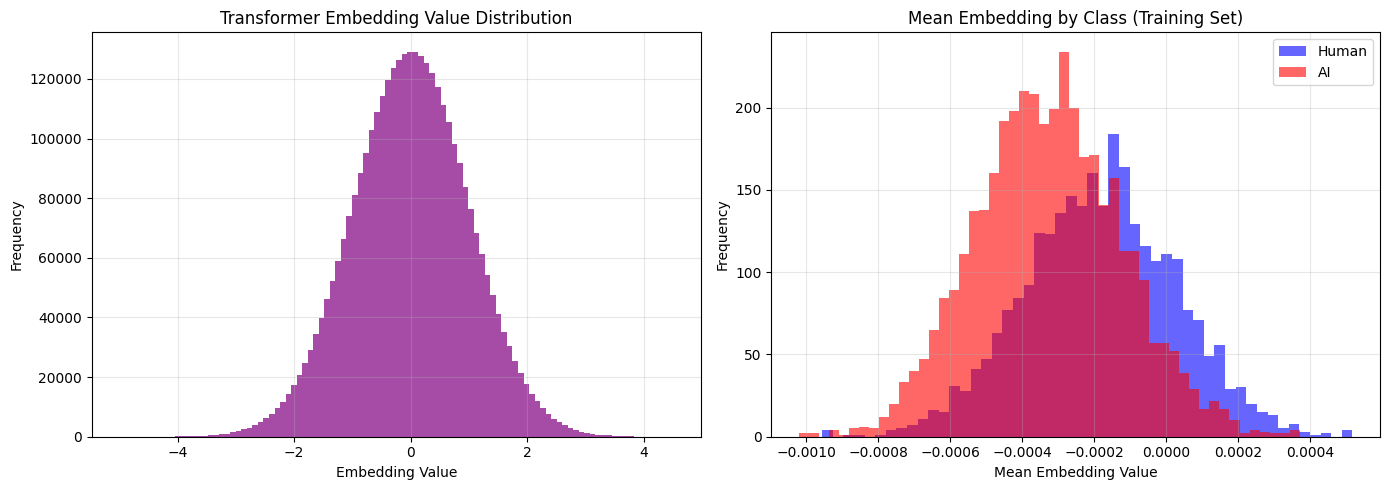


PHASE 2B COMPLETE: Transformer Encoder Training & Embedding Extraction

  Outputs:
    - checkpoints/transformer_encoder_best.pth
    - embeddings/transformer_embeddings.npz
    - results/transformer_encoder_training.png
    - results/transformer_embeddings_distribution.png

  Next: Run Phase 3 (Train Baseline Models) or Phase 4 (Train Hybrid Model)
CPU times: user 13min 58s, sys: 449 ms, total: 13min 58s
Wall time: 13min 53s


In [25]:
%%time
if RUN_PHASE_2B_EXTRACT_EMBEDDINGS:
    print("\n Extracting transformer embeddings for all samples...")
    print(f"  Target embedding dimension: {TRANSFORMER_DIM}\n")
    
    # Extract embeddings for each split
    print("Processing training set...")
    train_embeddings = extract_transformer_embeddings(X_train, transformer_encoder, batch_size=32)
    
    print("\nProcessing validation set...")
    val_embeddings = extract_transformer_embeddings(X_val, transformer_encoder, batch_size=32)
    
    print("\nProcessing test set...")
    test_embeddings = extract_transformer_embeddings(X_test, transformer_encoder, batch_size=32)
    
    print(f"\n✓ Extraction complete!")
    print(f"  Train embeddings: {train_embeddings.shape}")
    print(f"  Val embeddings: {val_embeddings.shape}")
    print(f"  Test embeddings: {test_embeddings.shape}")
    
    # Save embeddings
    np.savez_compressed(
        f"{OUTPUT_DIR}/embeddings/transformer_embeddings.npz",
        train_embeddings=train_embeddings,
        val_embeddings=val_embeddings,
        test_embeddings=test_embeddings
    )
    
    # Check file size
    embeddings_size = os.path.getsize(f"{OUTPUT_DIR}/embeddings/transformer_embeddings.npz") / 1024**2
    
    print(f"\nSaved to embeddings/transformer_embeddings.npz: {embeddings_size:.1f} MB")
    
    # Analyze embedding statistics
    print(f"\n Embedding Statistics:")
    print(f"    Train - Mean: {train_embeddings.mean():.4f}, Std: {train_embeddings.std():.4f}")
    print(f"    Train - Min: {train_embeddings.min():.4f}, Max: {train_embeddings.max():.4f}")
    
    # Visualize embedding distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Embedding value distribution
    axes[0].hist(train_embeddings.flatten(), bins=100, alpha=0.7, color='purple')
    axes[0].set_xlabel('Embedding Value')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Transformer Embedding Value Distribution')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Mean embedding per sample
    mean_embeddings = train_embeddings.mean(axis=1)
    axes[1].hist(mean_embeddings[y_train==0], bins=50, alpha=0.6, label='Human', color='blue')
    axes[1].hist(mean_embeddings[y_train==1], bins=50, alpha=0.6, label='AI', color='red')
    axes[1].set_xlabel('Mean Embedding Value')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Mean Embedding by Class (Training Set)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/results/transformer_embeddings_distribution.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*80)
    print("PHASE 2B COMPLETE: Transformer Encoder Training & Embedding Extraction")
    print("="*80)
    print(f"\n  Outputs:")
    print(f"    - checkpoints/transformer_encoder_best.pth")
    print(f"    - embeddings/transformer_embeddings.npz")
    print(f"    - results/transformer_encoder_training.png")
    print(f"    - results/transformer_embeddings_distribution.png")
    print(f"\n  Next: Run Phase 3 (Train Baseline Models) or Phase 4 (Train Hybrid Model)")

### Load Cached Embeddings (for subsequent phases)

In [ ]:
# This cell loads cached embeddings if Phases 2A/2B were skipped
# Run this if you're restarting and continuing from Phase 3+

if not RUN_PHASE_2A_TRAIN_AE or not RUN_PHASE_2B_EXTRACT_EMBEDDINGS:
    print("\\n Loading cached embeddings from disk...\\n")
    
    try:
        # Load AE latents if Phase 2A was skipped
        if not RUN_PHASE_2A_TRAIN_AE:
            ae_data = np.load(f"{OUTPUT_DIR}/embeddings/ae_latents.npz")
            train_latents = ae_data['train_latents']
            val_latents = ae_data['val_latents']
            test_latents = ae_data['test_latents']
            
            ae_losses_data = np.load(f"{OUTPUT_DIR}/embeddings/ae_losses.npz")
            train_losses = ae_losses_data['train_losses']
            val_losses = ae_losses_data['val_losses']
            test_losses = ae_losses_data['test_losses']
            
            print(f"✓ AE latents loaded:")
            print(f"  Train: {train_latents.shape}")
            print(f"  Val: {val_latents.shape}")
            print(f"  Test: {test_latents.shape}")
        
        # Load Transformer embeddings if Phase 2B was skipped
        if not RUN_PHASE_2B_EXTRACT_EMBEDDINGS:
            transformer_data = np.load(f"{OUTPUT_DIR}/embeddings/transformer_embeddings.npz")
            train_embeddings = transformer_data['train_embeddings']
            val_embeddings = transformer_data['val_embeddings']
            test_embeddings = transformer_data['test_embeddings']
            
            print(f"\\n✓ Transformer embeddings loaded:")
            print(f"  Train: {train_embeddings.shape}")
            print(f"  Val: {val_embeddings.shape}")
            print(f"  Test: {test_embeddings.shape}")
        
        print("\\n✓ All cached embeddings loaded successfully")
        
    except FileNotFoundError as e:
        print(f"\\n ERROR: Could not find cached embeddings!")
        print(f"  {e}")
        print(f"\\n  Please run Phase 2A and/or Phase 2B first to generate embeddings.")
        print(f"  Or check that OUTPUT_DIR is set correctly: {OUTPUT_DIR}")
else:
    print("\\n✓ Embeddings already in memory from Phase 2A/2B")

---
# Phase 3: Train Baseline Models
---

**Estimated Runtime**: 4-5 hours

**Tasks**:
1. Train CNN-only classifier (baseline 1)
2. Train AE-only classifier using reconstruction loss (baseline 2)
3. Train Transformer-only classifier (baseline 3)
4. Save best checkpoints for each model

**Outputs**:
- `checkpoints/cnn_best.pth` (~500 MB)
- `checkpoints/ae_classifier_best.pth` (~100 MB)
- `checkpoints/transformer_classifier_best.pth` (~200 MB)

**Note**: Models can be trained in parallel if multiple GPUs are available

### 3.1 Define Baseline Model Architectures

In [26]:
if RUN_PHASE_3_TRAIN_BASELINES:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    
    # =========================================================================
    # Baseline 1: CNN-only Classifier
    # =========================================================================
    
    class CNNClassifier(nn.Module):
        """
        CNN classifier for mel-spectrograms.
        Similar architecture to AE encoder but with classification head.
        """
        
        def __init__(self, num_classes=2, input_channels=1):
            super(CNNClassifier, self).__init__()
            
            # Convolutional layers
            self.features = nn.Sequential(
                # Layer 1
                nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout2d(0.25),
                
                # Layer 2
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout2d(0.25),
                
                # Layer 3
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout2d(0.3),
                
                # Layer 4
                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Dropout2d(0.3),
            )
            
            # Global average pooling
            self.gap = nn.AdaptiveAvgPool2d((1, 1))
            
            # Classification head
            self.classifier = nn.Sequential(
                nn.Linear(256, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),
                nn.Linear(128, num_classes)
            )
        
        def forward(self, x):
            x = self.features(x)
            x = self.gap(x)
            x = x.view(x.size(0), -1)
            x = self.classifier(x)
            return x
    
    # =========================================================================
    # Baseline 2: AE-only Classifier (using reconstruction loss)
    # =========================================================================
    
    class AEClassifier(nn.Module):
        """
        Simple classifier using AE latent vectors.
        """
        
        def __init__(self, latent_dim=AE_LATENT_DIM, num_classes=2):
            super(AEClassifier, self).__init__()
            
            self.classifier = nn.Sequential(
                nn.Linear(latent_dim, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                
                nn.Linear(128, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                
                nn.Linear(64, num_classes)
            )
        
        def forward(self, x):
            return self.classifier(x)
    
    # =========================================================================
    # Baseline 3: Transformer-only Classifier
    # =========================================================================
    
    class TransformerClassifier(nn.Module):
        """
        Simple classifier using transformer embeddings.
        """
        
        def __init__(self, embedding_dim=TRANSFORMER_DIM, num_classes=2):
            super(TransformerClassifier, self).__init__()
            
            self.classifier = nn.Sequential(
                nn.Linear(embedding_dim, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                
                nn.Linear(256, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                
                nn.Linear(128, num_classes)
            )
        
        def forward(self, x):
            return self.classifier(x)
    
    print("✓ Baseline model architectures defined:")
    print("  1. CNNClassifier - Direct spectrogram classification")
    print("  2. AEClassifier - Using AE latent vectors")
    print("  3. TransformerClassifier - Using transformer embeddings")

else:
    print(" Skipping Phase 3: Train Baseline Models")

✓ Baseline model architectures defined:
  1. CNNClassifier - Direct spectrogram classification
  2. AEClassifier - Using AE latent vectors
  3. TransformerClassifier - Using transformer embeddings


### 3.2 Create Datasets for Baseline Training

In [27]:
if RUN_PHASE_3_TRAIN_BASELINES:
    from torch.utils.data import TensorDataset, DataLoader
    
    # =========================================================================
    # Dataset 1: CNN - uses raw spectrograms
    # =========================================================================
    train_dataset_cnn = SpectrogramDataset(X_train, y_train)
    val_dataset_cnn = SpectrogramDataset(X_val, y_val)
    test_dataset_cnn = SpectrogramDataset(X_test, y_test)
    
    train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader_cnn = DataLoader(val_dataset_cnn, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    # =========================================================================
    # Dataset 2: AE Classifier - uses AE latent vectors
    # =========================================================================
    train_dataset_ae_clf = TensorDataset(
        torch.from_numpy(train_latents).float(),
        torch.from_numpy(y_train).long()
    )
    val_dataset_ae_clf = TensorDataset(
        torch.from_numpy(val_latents).float(),
        torch.from_numpy(y_val).long()
    )
    test_dataset_ae_clf = TensorDataset(
        torch.from_numpy(test_latents).float(),
        torch.from_numpy(y_test).long()
    )
    
    train_loader_ae_clf = DataLoader(train_dataset_ae_clf, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader_ae_clf = DataLoader(val_dataset_ae_clf, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader_ae_clf = DataLoader(test_dataset_ae_clf, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    # =========================================================================
    # Dataset 3: Transformer Classifier - uses transformer embeddings
    # =========================================================================
    train_dataset_trans = TensorDataset(
        torch.from_numpy(train_embeddings).float(),
        torch.from_numpy(y_train).long()
    )
    val_dataset_trans = TensorDataset(
        torch.from_numpy(val_embeddings).float(),
        torch.from_numpy(y_val).long()
    )
    test_dataset_trans = TensorDataset(
        torch.from_numpy(test_embeddings).float(),
        torch.from_numpy(y_test).long()
    )
    
    train_loader_trans = DataLoader(train_dataset_trans, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader_trans = DataLoader(val_dataset_trans, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader_trans = DataLoader(test_dataset_trans, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    print("✓ Datasets created for baseline training:")
    print(f"  CNN: {len(train_dataset_cnn)} train, {len(val_dataset_cnn)} val, {len(test_dataset_cnn)} test")
    print(f"  AE: {len(train_dataset_ae_clf)} train, {len(val_dataset_ae_clf)} val, {len(test_dataset_ae_clf)} test")
    print(f"  Transformer: {len(train_dataset_trans)} train, {len(val_dataset_trans)} val, {len(test_dataset_trans)} test")

✓ Datasets created for baseline training:
  CNN: 6668 train, 1058 val, 1021 test
  AE: 6668 train, 1058 val, 1021 test
  Transformer: 6668 train, 1058 val, 1021 test


### 3.3 Training Functions for Classifiers

In [28]:
if RUN_PHASE_3_TRAIN_BASELINES:
    
    def train_classifier_epoch(model, dataloader, criterion, optimizer, device):
        """Train classifier for one epoch."""
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for data, labels in tqdm(dataloader, desc="Training", leave=False):
            data, labels = data.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        accuracy = 100 * correct / total
        return avg_loss, accuracy
    
    def validate_classifier(model, dataloader, criterion, device):
        """Validate classifier."""
        model.eval()
        total_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, labels in tqdm(dataloader, desc="Validating", leave=False):
                data, labels = data.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(data)
                loss = criterion(outputs, labels)
                
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        accuracy = 100 * correct / total
        return avg_loss, accuracy
    
    def train_classifier(model, train_loader, val_loader, model_name, num_epochs=NUM_EPOCHS_CLASSIFIER):
        """Complete training loop for a classifier."""
        print(f"\\n{'='*80}")
        print(f"Training {model_name}")
        print(f"{'='*80}\\n")
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        
        train_losses, train_accs = [], []
        val_losses, val_accs = [], []
        best_val_acc = 0
        patience_counter = 0
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            epoch_start = time.time()
            
            # Train
            train_loss, train_acc = train_classifier_epoch(model, train_loader, criterion, optimizer, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            
            # Validate
            val_loss, val_acc = validate_classifier(model, val_loader, criterion, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            
            epoch_time = time.time() - epoch_start
            
            print(f"Epoch [{epoch+1}/{num_epochs}] - "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | "
                  f"Time: {epoch_time:.1f}s")
            
            # Save last checkpoint
            save_checkpoint(
                model, optimizer, epoch, val_loss,
                f"{OUTPUT_DIR}/checkpoints/{model_name}_last.pth"
            )
            
            # Check if best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                save_checkpoint(
                    model, optimizer, epoch, val_loss,
                    f"{OUTPUT_DIR}/checkpoints/{model_name}_best.pth",
                    is_best=True
                )
            else:
                patience_counter += 1
            
            # Early stopping
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"\\n Early stopping triggered after {epoch+1} epochs")
                break
        
        total_time = time.time() - start_time
        
        print(f"\\n✓ {model_name} training complete!")
        print(f"  Total time: {total_time/60:.1f} minutes")
        print(f"  Best validation accuracy: {best_val_acc:.2f}%")
        
        return {
            'train_losses': train_losses,
            'train_accs': train_accs,
            'val_losses': val_losses,
            'val_accs': val_accs,
            'best_val_acc': best_val_acc
        }
    
    print("✓ Classifier training functions defined")

✓ Classifier training functions defined


### 3.4 Train CNN Baseline

In [38]:
%%time
if RUN_PHASE_3_TRAIN_BASELINES:
    # Initialize and train CNN model
    model_cnn = CNNClassifier(num_classes=2).to(device)
    results_cnn = train_classifier(model_cnn, train_loader_cnn, val_loader_cnn, "cnn")

\n================================================================================
Training cnn
================================================================================\n


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [1/30] - Train Loss: 0.6335, Train Acc: 65.10% | Val Loss: 0.6191, Val Acc: 66.16% | Time: 7.7s
  Saved best model: /kaggle/working/checkpoints/cnn_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [2/30] - Train Loss: 0.6061, Train Acc: 67.70% | Val Loss: 0.6007, Val Acc: 68.43% | Time: 7.6s
  Saved best model: /kaggle/working/checkpoints/cnn_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [3/30] - Train Loss: 0.5849, Train Acc: 70.20% | Val Loss: 0.5907, Val Acc: 69.19% | Time: 7.7s
  Saved best model: /kaggle/working/checkpoints/cnn_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [4/30] - Train Loss: 0.5679, Train Acc: 71.39% | Val Loss: 0.5878, Val Acc: 69.66% | Time: 7.6s
  Saved best model: /kaggle/working/checkpoints/cnn_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [5/30] - Train Loss: 0.5580, Train Acc: 72.14% | Val Loss: 0.5793, Val Acc: 70.42% | Time: 7.5s
  Saved best model: /kaggle/working/checkpoints/cnn_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [6/30] - Train Loss: 0.5418, Train Acc: 73.47% | Val Loss: 0.5702, Val Acc: 70.89% | Time: 7.4s
  Saved best model: /kaggle/working/checkpoints/cnn_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [7/30] - Train Loss: 0.5449, Train Acc: 72.77% | Val Loss: 0.5647, Val Acc: 71.64% | Time: 7.4s
  Saved best model: /kaggle/working/checkpoints/cnn_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [8/30] - Train Loss: 0.5316, Train Acc: 73.85% | Val Loss: 0.5725, Val Acc: 71.64% | Time: 7.4s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [9/30] - Train Loss: 0.5250, Train Acc: 74.91% | Val Loss: 0.5557, Val Acc: 71.64% | Time: 7.4s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [10/30] - Train Loss: 0.5064, Train Acc: 75.90% | Val Loss: 0.5195, Val Acc: 74.48% | Time: 7.3s
  Saved best model: /kaggle/working/checkpoints/cnn_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [11/30] - Train Loss: 0.4912, Train Acc: 77.05% | Val Loss: 0.4739, Val Acc: 76.37% | Time: 7.3s
  Saved best model: /kaggle/working/checkpoints/cnn_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [12/30] - Train Loss: 0.4639, Train Acc: 78.22% | Val Loss: 0.4413, Val Acc: 78.64% | Time: 7.3s
  Saved best model: /kaggle/working/checkpoints/cnn_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [13/30] - Train Loss: 0.4419, Train Acc: 80.43% | Val Loss: 0.3740, Val Acc: 83.27% | Time: 7.4s
  Saved best model: /kaggle/working/checkpoints/cnn_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [14/30] - Train Loss: 0.4191, Train Acc: 81.60% | Val Loss: 0.3669, Val Acc: 84.40% | Time: 7.4s
  Saved best model: /kaggle/working/checkpoints/cnn_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [15/30] - Train Loss: 0.3978, Train Acc: 83.07% | Val Loss: 0.3706, Val Acc: 82.89% | Time: 7.4s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [16/30] - Train Loss: 0.3799, Train Acc: 83.74% | Val Loss: 0.3323, Val Acc: 85.82% | Time: 7.4s
  Saved best model: /kaggle/working/checkpoints/cnn_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [17/30] - Train Loss: 0.3598, Train Acc: 84.70% | Val Loss: 0.3186, Val Acc: 86.67% | Time: 7.3s
  Saved best model: /kaggle/working/checkpoints/cnn_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [18/30] - Train Loss: 0.3418, Train Acc: 85.54% | Val Loss: 0.3087, Val Acc: 86.86% | Time: 7.3s
  Saved best model: /kaggle/working/checkpoints/cnn_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [19/30] - Train Loss: 0.3190, Train Acc: 86.86% | Val Loss: 0.2770, Val Acc: 89.04% | Time: 7.3s
  Saved best model: /kaggle/working/checkpoints/cnn_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [20/30] - Train Loss: 0.2936, Train Acc: 87.88% | Val Loss: 0.2548, Val Acc: 89.79% | Time: 7.4s
  Saved best model: /kaggle/working/checkpoints/cnn_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [21/30] - Train Loss: 0.2727, Train Acc: 88.77% | Val Loss: 0.2271, Val Acc: 91.97% | Time: 7.3s
  Saved best model: /kaggle/working/checkpoints/cnn_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [22/30] - Train Loss: 0.2496, Train Acc: 90.06% | Val Loss: 0.2621, Val Acc: 89.32% | Time: 7.3s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [23/30] - Train Loss: 0.2373, Train Acc: 90.40% | Val Loss: 0.2249, Val Acc: 91.59% | Time: 7.3s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [24/30] - Train Loss: 0.2232, Train Acc: 91.03% | Val Loss: 0.2130, Val Acc: 92.16% | Time: 7.3s
  Saved best model: /kaggle/working/checkpoints/cnn_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [25/30] - Train Loss: 0.2260, Train Acc: 90.87% | Val Loss: 0.2280, Val Acc: 91.30% | Time: 7.3s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [26/30] - Train Loss: 0.2183, Train Acc: 91.63% | Val Loss: 0.2231, Val Acc: 91.68% | Time: 7.3s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [27/30] - Train Loss: 0.2066, Train Acc: 92.01% | Val Loss: 0.2147, Val Acc: 91.87% | Time: 7.3s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [28/30] - Train Loss: 0.2014, Train Acc: 92.25% | Val Loss: 0.2044, Val Acc: 92.44% | Time: 7.3s
  Saved best model: /kaggle/working/checkpoints/cnn_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [29/30] - Train Loss: 0.1902, Train Acc: 92.55% | Val Loss: 0.2044, Val Acc: 92.16% | Time: 7.4s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [30/30] - Train Loss: 0.1963, Train Acc: 92.59% | Val Loss: 0.2190, Val Acc: 91.49% | Time: 7.4s
\n✓ cnn training complete!
  Total time: 3.7 minutes
  Best validation accuracy: 92.44%
CPU times: user 3min 41s, sys: 1.53 s, total: 3min 43s
Wall time: 3min 42s


### 3.5 Train AE Classifier Baseline

In [39]:
%%time
if RUN_PHASE_3_TRAIN_BASELINES:
    # Initialize and train AE Classifier
    model_ae_clf = AEClassifier(latent_dim=AE_LATENT_DIM, num_classes=2).to(device)
    results_ae_clf = train_classifier(model_ae_clf, train_loader_ae_clf, val_loader_ae_clf, "ae_classifier")

\n================================================================================
Training ae_classifier
================================================================================\n


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [1/30] - Train Loss: 0.2846, Train Acc: 93.00% | Val Loss: 0.2519, Val Acc: 91.97% | Time: 0.6s
  Saved best model: /kaggle/working/checkpoints/ae_classifier_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [2/30] - Train Loss: 0.1347, Train Acc: 97.87% | Val Loss: 0.2382, Val Acc: 91.40% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [3/30] - Train Loss: 0.0981, Train Acc: 98.02% | Val Loss: 0.2250, Val Acc: 91.68% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [4/30] - Train Loss: 0.0747, Train Acc: 98.23% | Val Loss: 0.2242, Val Acc: 92.06% | Time: 0.6s
  Saved best model: /kaggle/working/checkpoints/ae_classifier_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [5/30] - Train Loss: 0.0664, Train Acc: 98.22% | Val Loss: 0.2599, Val Acc: 91.21% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [6/30] - Train Loss: 0.0587, Train Acc: 98.40% | Val Loss: 0.2509, Val Acc: 92.16% | Time: 0.6s
  Saved best model: /kaggle/working/checkpoints/ae_classifier_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [7/30] - Train Loss: 0.0513, Train Acc: 98.49% | Val Loss: 0.2511, Val Acc: 92.06% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [8/30] - Train Loss: 0.0462, Train Acc: 98.50% | Val Loss: 0.2762, Val Acc: 91.49% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [9/30] - Train Loss: 0.0477, Train Acc: 98.43% | Val Loss: 0.2881, Val Acc: 91.02% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [10/30] - Train Loss: 0.0405, Train Acc: 98.80% | Val Loss: 0.2741, Val Acc: 92.25% | Time: 0.6s
  Saved best model: /kaggle/working/checkpoints/ae_classifier_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [11/30] - Train Loss: 0.0395, Train Acc: 98.58% | Val Loss: 0.2898, Val Acc: 91.59% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [12/30] - Train Loss: 0.0411, Train Acc: 98.67% | Val Loss: 0.3227, Val Acc: 91.02% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [13/30] - Train Loss: 0.0351, Train Acc: 98.94% | Val Loss: 0.2866, Val Acc: 91.78% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [14/30] - Train Loss: 0.0368, Train Acc: 98.77% | Val Loss: 0.3080, Val Acc: 92.25% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [15/30] - Train Loss: 0.0450, Train Acc: 98.37% | Val Loss: 0.3066, Val Acc: 91.97% | Time: 0.6s
\n Early stopping triggered after 15 epochs
\n✓ ae_classifier training complete!
  Total time: 0.1 minutes
  Best validation accuracy: 92.25%
CPU times: user 8.44 s, sys: 231 ms, total: 8.67 s
Wall time: 8.7 s


### 3.6 Train Transformer Classifier Baseline

In [40]:
%%time
if RUN_PHASE_3_TRAIN_BASELINES:
    # Initialize and train Transformer Classifier
    model_trans_clf = TransformerClassifier(embedding_dim=TRANSFORMER_DIM, num_classes=2).to(device)
    results_trans_clf = train_classifier(model_trans_clf, train_loader_trans, val_loader_trans, "transformer_classifier")
    
    print("\\n" + "="*80)
    print(" PHASE 3 COMPLETE: Baseline Models Training")
    print("="*80)
    print(f"\\n  Best Validation Accuracies:")
    print(f"    CNN Baseline: {results_cnn['best_val_acc']:.2f}%")
    print(f"    AE Baseline: {results_ae_clf['best_val_acc']:.2f}%")
    print(f"    Transformer Baseline: {results_trans_clf['best_val_acc']:.2f}%")
    print(f"\\n  Outputs:")
    print(f"    - checkpoints/cnn_best.pth")
    print(f"    - checkpoints/ae_classifier_best.pth")
    print(f"    - checkpoints/transformer_classifier_best.pth")

\n================================================================================
Training transformer_classifier
================================================================================\n


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [1/30] - Train Loss: 0.3723, Train Acc: 84.04% | Val Loss: 0.4369, Val Acc: 79.87% | Time: 0.6s
  Saved best model: /kaggle/working/checkpoints/transformer_classifier_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [2/30] - Train Loss: 0.2880, Train Acc: 88.12% | Val Loss: 0.4332, Val Acc: 80.34% | Time: 0.6s
  Saved best model: /kaggle/working/checkpoints/transformer_classifier_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [3/30] - Train Loss: 0.2692, Train Acc: 88.81% | Val Loss: 0.4153, Val Acc: 81.95% | Time: 0.6s
  Saved best model: /kaggle/working/checkpoints/transformer_classifier_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [4/30] - Train Loss: 0.2597, Train Acc: 89.62% | Val Loss: 0.4543, Val Acc: 79.68% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [5/30] - Train Loss: 0.2532, Train Acc: 89.73% | Val Loss: 0.4149, Val Acc: 82.61% | Time: 0.6s
  Saved best model: /kaggle/working/checkpoints/transformer_classifier_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [6/30] - Train Loss: 0.2364, Train Acc: 90.81% | Val Loss: 0.4508, Val Acc: 80.34% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [7/30] - Train Loss: 0.2367, Train Acc: 90.49% | Val Loss: 0.4155, Val Acc: 82.89% | Time: 0.6s
  Saved best model: /kaggle/working/checkpoints/transformer_classifier_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [8/30] - Train Loss: 0.2310, Train Acc: 90.55% | Val Loss: 0.4364, Val Acc: 80.91% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [9/30] - Train Loss: 0.2204, Train Acc: 90.94% | Val Loss: 0.4107, Val Acc: 83.46% | Time: 0.6s
  Saved best model: /kaggle/working/checkpoints/transformer_classifier_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [10/30] - Train Loss: 0.2236, Train Acc: 91.35% | Val Loss: 0.4108, Val Acc: 84.03% | Time: 0.6s
  Saved best model: /kaggle/working/checkpoints/transformer_classifier_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [11/30] - Train Loss: 0.2080, Train Acc: 91.53% | Val Loss: 0.4241, Val Acc: 82.51% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [12/30] - Train Loss: 0.2018, Train Acc: 91.84% | Val Loss: 0.4181, Val Acc: 83.65% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [13/30] - Train Loss: 0.2015, Train Acc: 92.02% | Val Loss: 0.4132, Val Acc: 83.93% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [14/30] - Train Loss: 0.2016, Train Acc: 91.87% | Val Loss: 0.4226, Val Acc: 82.33% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [15/30] - Train Loss: 0.1920, Train Acc: 92.44% | Val Loss: 0.4001, Val Acc: 84.22% | Time: 0.6s
  Saved best model: /kaggle/working/checkpoints/transformer_classifier_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [16/30] - Train Loss: 0.1904, Train Acc: 92.62% | Val Loss: 0.4646, Val Acc: 80.53% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [17/30] - Train Loss: 0.1847, Train Acc: 92.55% | Val Loss: 0.4088, Val Acc: 83.65% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [18/30] - Train Loss: 0.1829, Train Acc: 93.01% | Val Loss: 0.4267, Val Acc: 84.69% | Time: 0.6s
  Saved best model: /kaggle/working/checkpoints/transformer_classifier_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [19/30] - Train Loss: 0.1839, Train Acc: 92.38% | Val Loss: 0.4467, Val Acc: 82.51% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [20/30] - Train Loss: 0.1713, Train Acc: 93.27% | Val Loss: 0.4698, Val Acc: 81.47% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [21/30] - Train Loss: 0.1678, Train Acc: 93.37% | Val Loss: 0.4892, Val Acc: 80.53% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [22/30] - Train Loss: 0.1705, Train Acc: 92.91% | Val Loss: 0.4426, Val Acc: 83.55% | Time: 0.6s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [23/30] - Train Loss: 0.1602, Train Acc: 93.69% | Val Loss: 0.4382, Val Acc: 83.65% | Time: 0.6s
\n Early stopping triggered after 23 epochs
\n✓ transformer_classifier training complete!
  Total time: 0.2 minutes
  Best validation accuracy: 84.69%
\n================================================================================
 PHASE 3 COMPLETE: Baseline Models Training
\n  Best Validation Accuracies:
    CNN Baseline: 92.44%
    AE Baseline: 92.25%
    Transformer Baseline: 84.69%
\n  Outputs:
    - checkpoints/cnn_best.pth
    - checkpoints/ae_classifier_best.pth
    - checkpoints/transformer_classifier_best.pth
CPU times: user 13.1 s, sys: 391 ms, total: 13.5 s
Wall time: 13.6 s


---
# Phase 4: Train Hybrid Model (IMPROVED)
---

**Estimated Runtime**: 3-4 hours

**Tasks**:
1. Concatenate AE latents (256-dim) + Transformer embeddings (512-dim)
2. **[NEW]** Apply attention-based fusion to weight features dynamically
3. Train improved MLP fusion classifier on attended features (768-dim)
4. Save best hybrid model

**Outputs**:
- `checkpoints/hybrid_best.pth` (~200 MB)

**Requirements**: Phases 2A and 2B must be completed

**Improvements**: Attention mechanism allows model to focus on most discriminative features

### 4.1 Define Hybrid Model with Attention Fusion (IMPROVED)

In [41]:
if RUN_PHASE_4_TRAIN_HYBRID:
    
    class AttentionFusion(nn.Module):
        """
        Attention mechanism to dynamically weight AE and Transformer features.
        Learns which feature source is more important for each sample.
        """
        def __init__(self, ae_dim, trans_dim):
            super(AttentionFusion, self).__init__()
            
            self.ae_dim = ae_dim
            self.trans_dim = trans_dim
            
            # Project both features to common dimension for attention
            self.ae_proj = nn.Linear(ae_dim, 256)
            self.trans_proj = nn.Linear(trans_dim, 256)
            
            # Attention scoring
            self.attention = nn.Sequential(
                nn.Linear(256, 128),
                nn.Tanh(),
                nn.Linear(128, 1)
            )
        
        def forward(self, ae_features, trans_features):
            """
            Args:
                ae_features: (B, ae_dim) - Autoencoder latents
                trans_features: (B, trans_dim) - Transformer embeddings
            
            Returns:
                fused: (B, ae_dim + trans_dim) - Attention-weighted concatenation
                ae_weight: (B, 1) - Attention weight for AE features
                trans_weight: (B, 1) - Attention weight for Transformer features
            """
            # Project to common space
            ae_proj = self.ae_proj(ae_features)  # (B, 256)
            trans_proj = self.trans_proj(trans_features)  # (B, 256)
            
            # Compute attention scores
            ae_score = self.attention(ae_proj)  # (B, 1)
            trans_score = self.attention(trans_proj)  # (B, 1)
            
            # Softmax to get weights
            scores = torch.cat([ae_score, trans_score], dim=1)  # (B, 2)
            weights = F.softmax(scores, dim=1)  # (B, 2)
            
            ae_weight = weights[:, 0:1]  # (B, 1)
            trans_weight = weights[:, 1:2]  # (B, 1)
            
            # Apply attention weights
            ae_weighted = ae_features * ae_weight  # (B, ae_dim)
            trans_weighted = trans_features * trans_weight  # (B, trans_dim)
            
            # Concatenate weighted features
            fused = torch.cat([ae_weighted, trans_weighted], dim=1)  # (B, ae_dim + trans_dim)
            
            return fused, ae_weight, trans_weight
    
    
    class HybridClassifier(nn.Module):
        """
        Improved hybrid classifier with attention-based fusion.
        
        Features:
        1. Attention mechanism to weight AE vs Transformer features
        2. Deep MLP classifier on fused features
        3. Residual connections for better gradient flow
        
        Input: AE latents (256-dim) + Transformer embeddings (512-dim)
        Output: Binary classification (AI vs Human)
        """
        
        def __init__(self, ae_dim=AE_LATENT_DIM, trans_dim=TRANSFORMER_DIM, num_classes=2):
            super(HybridClassifier, self).__init__()
            
            self.ae_dim = ae_dim
            self.trans_dim = trans_dim
            combined_dim = ae_dim + trans_dim  # 768
            
            # Attention fusion
            self.attention_fusion = AttentionFusion(ae_dim, trans_dim)
            
            # MLP classifier
            self.classifier = nn.Sequential(
                # Layer 1
                nn.Linear(combined_dim, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),
                
                # Layer 2
                nn.Linear(512, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                
                # Layer 3
                nn.Linear(256, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                
                # Output layer
                nn.Linear(128, num_classes)
            )
        
        def forward(self, x, return_attention=False):
            """
            Args:
                x: (B, ae_dim + trans_dim) - Concatenated features
                return_attention: If True, also return attention weights
            
            Returns:
                logits: (B, num_classes)
                (optional) ae_weight, trans_weight: Attention weights
            """
            # Split concatenated features
            ae_features = x[:, :self.ae_dim]  # (B, ae_dim)
            trans_features = x[:, self.ae_dim:]  # (B, trans_dim)
            
            # Apply attention fusion
            fused, ae_weight, trans_weight = self.attention_fusion(ae_features, trans_features)
            
            # Classify
            logits = self.classifier(fused)
            
            if return_attention:
                return logits, ae_weight, trans_weight
            else:
                return logits
    
    print("✓ Improved hybrid model architecture defined")
    print(f"  Input dimension: {AE_LATENT_DIM + TRANSFORMER_DIM} (AE: {AE_LATENT_DIM} + Transformer: {TRANSFORMER_DIM})")
    print(f"  Features: Attention-based fusion mechanism")
    print(f"  Output: 2 classes (AI vs Human)")

else:
    print("Skipping Phase 4: Train Hybrid Model")

✓ Improved hybrid model architecture defined
  Input dimension: 768 (AE: 256 + Transformer: 512)
  Features: Attention-based fusion mechanism
  Output: 2 classes (AI vs Human)


### 4.2 Create Hybrid Dataset (Concatenated Features)

In [42]:
if RUN_PHASE_4_TRAIN_HYBRID:
    print("\\n Concatenating AE latents and Transformer embeddings...")
    
    # Concatenate features
    train_hybrid_features = np.concatenate([train_latents, train_embeddings], axis=1)
    val_hybrid_features = np.concatenate([val_latents, val_embeddings], axis=1)
    test_hybrid_features = np.concatenate([test_latents, test_embeddings], axis=1)
    
    print(f"  Train features: {train_hybrid_features.shape}")
    print(f"  Val features: {val_hybrid_features.shape}")
    print(f"  Test features: {test_hybrid_features.shape}")
    
    # Create datasets
    train_dataset_hybrid = TensorDataset(
        torch.from_numpy(train_hybrid_features).float(),
        torch.from_numpy(y_train).long()
    )
    val_dataset_hybrid = TensorDataset(
        torch.from_numpy(val_hybrid_features).float(),
        torch.from_numpy(y_val).long()
    )
    test_dataset_hybrid = TensorDataset(
        torch.from_numpy(test_hybrid_features).float(),
        torch.from_numpy(y_test).long()
    )
    
    # Create dataloaders
    train_loader_hybrid = DataLoader(train_dataset_hybrid, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader_hybrid = DataLoader(val_dataset_hybrid, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader_hybrid = DataLoader(test_dataset_hybrid, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    print(f"\\n✓ Hybrid datasets created")
    print(f"  Feature dimension: {train_hybrid_features.shape[1]} (AE: {AE_LATENT_DIM} + Trans: {TRANSFORMER_DIM})")

\n Concatenating AE latents and Transformer embeddings...
  Train features: (6668, 768)
  Val features: (1058, 768)
  Test features: (1021, 768)
\n✓ Hybrid datasets created
  Feature dimension: 768 (AE: 256 + Trans: 512)


### 4.3 Train Hybrid Model


 Training Improved Hybrid Model with Attention Fusion...

\n================================================================================
Training hybrid
================================================================================\n


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [1/30] - Train Loss: 0.1830, Train Acc: 94.62% | Val Loss: 0.2267, Val Acc: 92.44% | Time: 1.0s
  Saved best model: /kaggle/working/checkpoints/hybrid_best.pth


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [2/30] - Train Loss: 0.0612, Train Acc: 98.59% | Val Loss: 0.2664, Val Acc: 90.83% | Time: 1.0s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [3/30] - Train Loss: 0.0476, Train Acc: 98.70% | Val Loss: 0.2558, Val Acc: 91.02% | Time: 1.0s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [4/30] - Train Loss: 0.0381, Train Acc: 99.10% | Val Loss: 0.2628, Val Acc: 91.78% | Time: 1.1s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [5/30] - Train Loss: 0.0309, Train Acc: 99.12% | Val Loss: 0.2563, Val Acc: 92.06% | Time: 1.0s


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Validating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch [6/30] - Train Loss: 0.0330, Train Acc: 98.95% | Val Loss: 0.2746, Val Acc: 91.87% | Time: 1.0s
\n Early stopping triggered after 6 epochs
\n✓ hybrid training complete!
  Total time: 0.1 minutes
  Best validation accuracy: 92.44%

 Analyzing Attention Weights...

  Average Attention Weights:
    AE Features: 0.6777 ± 0.3823
    Transformer Features: 0.3223 ± 0.3823

  Attention by Class:
    Human - AE: 0.9473, Trans: 0.0527
    AI    - AE: 0.3245, Trans: 0.6755


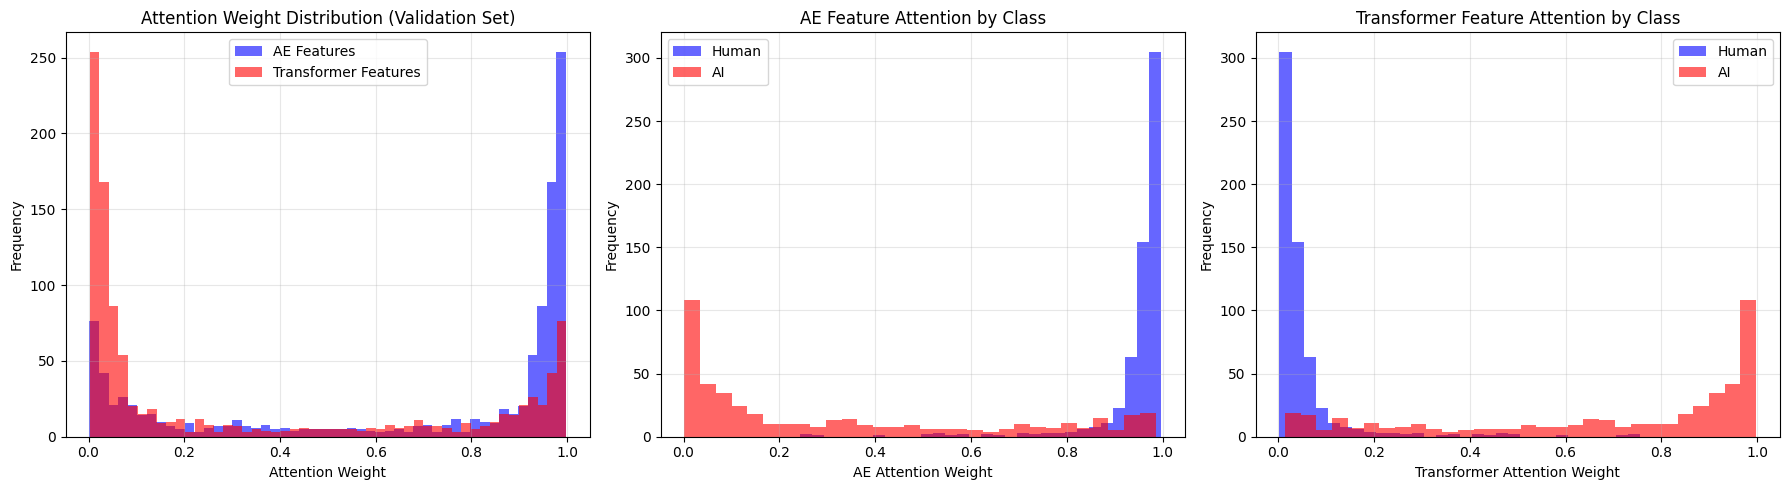


 PHASE 4 COMPLETE: Improved Hybrid Model Training

  Best Validation Accuracy: 92.44%

  Outputs:
    - checkpoints/hybrid_best.pth
    - results/hybrid_attention_analysis.png

  Next: Run Phase 5 (Evaluation & Visualization)
CPU times: user 7.98 s, sys: 174 ms, total: 8.15 s
Wall time: 8.19 s


In [43]:
%%time
if RUN_PHASE_4_TRAIN_HYBRID:
    print("\n Training Improved Hybrid Model with Attention Fusion...\n")
    
    # Initialize and train Hybrid model
    model_hybrid = HybridClassifier(ae_dim=AE_LATENT_DIM, trans_dim=TRANSFORMER_DIM, num_classes=2).to(device)
    results_hybrid = train_classifier(model_hybrid, train_loader_hybrid, val_loader_hybrid, "hybrid", num_epochs=NUM_EPOCHS_CLASSIFIER)
    
    # Analyze attention weights on validation set
    print("\n Analyzing Attention Weights...")
    model_hybrid.eval()
    
    all_ae_weights = []
    all_trans_weights = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in val_loader_hybrid:
            features = features.to(device)
            _, ae_weight, trans_weight = model_hybrid(features, return_attention=True)
            
            all_ae_weights.append(ae_weight.cpu().numpy())
            all_trans_weights.append(trans_weight.cpu().numpy())
            all_labels.append(labels.numpy())
    
    ae_weights = np.concatenate(all_ae_weights)
    trans_weights = np.concatenate(all_trans_weights)
    val_labels = np.concatenate(all_labels)
    
    print(f"\n  Average Attention Weights:")
    print(f"    AE Features: {ae_weights.mean():.4f} ± {ae_weights.std():.4f}")
    print(f"    Transformer Features: {trans_weights.mean():.4f} ± {trans_weights.std():.4f}")
    print(f"\n  Attention by Class:")
    print(f"    Human - AE: {ae_weights[val_labels==0].mean():.4f}, Trans: {trans_weights[val_labels==0].mean():.4f}")
    print(f"    AI    - AE: {ae_weights[val_labels==1].mean():.4f}, Trans: {trans_weights[val_labels==1].mean():.4f}")
    
    # Visualize attention distribution
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Attention weight distribution
    axes[0].hist(ae_weights, bins=50, alpha=0.6, label='AE Features', color='blue')
    axes[0].hist(trans_weights, bins=50, alpha=0.6, label='Transformer Features', color='red')
    axes[0].set_xlabel('Attention Weight')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Attention Weight Distribution (Validation Set)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Attention by class (AE)
    axes[1].hist(ae_weights[val_labels==0], bins=30, alpha=0.6, label='Human', color='blue')
    axes[1].hist(ae_weights[val_labels==1], bins=30, alpha=0.6, label='AI', color='red')
    axes[1].set_xlabel('AE Attention Weight')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('AE Feature Attention by Class')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Attention by class (Transformer)
    axes[2].hist(trans_weights[val_labels==0], bins=30, alpha=0.6, label='Human', color='blue')
    axes[2].hist(trans_weights[val_labels==1], bins=30, alpha=0.6, label='AI', color='red')
    axes[2].set_xlabel('Transformer Attention Weight')
    axes[2].set_ylabel('Frequency')
    axes[2].set_title('Transformer Feature Attention by Class')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/results/hybrid_attention_analysis.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*80)
    print(" PHASE 4 COMPLETE: Improved Hybrid Model Training")
    print("="*80)
    print(f"\n  Best Validation Accuracy: {results_hybrid['best_val_acc']:.2f}%")
    print(f"\n  Outputs:")
    print(f"    - checkpoints/hybrid_best.pth")
    print(f"    - results/hybrid_attention_analysis.png")
    print(f"\n  Next: Run Phase 5 (Evaluation & Visualization)")

### 4.4 (Optional) End-to-End Fine-Tuning

In [ ]:
%%time
# End-to-end fine-tuning (optional, advanced improvement)
# Set this to True to enable end-to-end fine-tuning after Phase 4
RUN_PHASE_4_FINETUNE = True

if RUN_PHASE_4_TRAIN_HYBRID and RUN_PHASE_4_FINETUNE:
    print("\n Starting End-to-End Fine-Tuning...")
    print("  This unfreezes feature extractors and fine-tunes the entire pipeline\n")
    
    class HybridEndToEnd(nn.Module):
        """
        End-to-end hybrid model that fine-tunes feature extractors.
        Combines autoencoder, transformer encoder, and classifier into one model.
        """
        def __init__(self, autoencoder, transformer_encoder, ae_dim, trans_dim, num_classes=2):
            super(HybridEndToEnd, self).__init__()
            
            # Extract encoder components from MultiTaskAutoencoder
            self.ae_encoder = autoencoder.encoder  # Convolutional encoder
            self.ae_fc_encode = autoencoder.fc_encode  # Linear layer to latent space
            
            # Transformer encoder (real AST or CNN fallback)
            self.trans_encoder = transformer_encoder
            
            self.ae_dim = ae_dim
            self.trans_dim = trans_dim
            
            # Attention fusion
            self.attention_fusion = AttentionFusion(ae_dim, trans_dim)
            
            # Classifier
            combined_dim = ae_dim + trans_dim
            self.classifier = nn.Sequential(
                nn.Linear(combined_dim, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),
                
                nn.Linear(512, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                
                nn.Linear(256, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                
                nn.Linear(128, num_classes)
            )
        
        def forward(self, x, return_attention=False):
            """
            Args:
                x: (B, 1, H, W) - Raw spectrograms
            Returns:
                logits: (B, num_classes)
            """
            # Extract AE features
            ae_feat = self.ae_encoder(x)  # Conv encoder output
            ae_feat = ae_feat.view(ae_feat.size(0), -1)  # Flatten
            ae_latent = self.ae_fc_encode(ae_feat)  # Project to latent space
            
            # Extract transformer features
            trans_embedding = self.trans_encoder(x, return_embedding=True)
            
            # Fuse with attention
            fused, ae_weight, trans_weight = self.attention_fusion(ae_latent, trans_embedding)
            
            # Classify
            logits = self.classifier(fused)
            
            if return_attention:
                return logits, ae_weight, trans_weight
            else:
                return logits
    
    # Check if AST is available
    if not AST_AVAILABLE:
        print(" WARNING: AST not available - end-to-end fine-tuning requires the real transformer!")
        print("  Please fix the CUDA/torchaudio issue to use real AST.")
        print("  Skipping end-to-end fine-tuning.\n")
    else:
        # Load best pretrained models
        print(" Loading pretrained models...")
        
        # Load autoencoder
        ae_checkpoint = torch.load(f"{OUTPUT_DIR}/checkpoints/ae_multitask_best.pth")
        pretrained_ae = MultiTaskAutoencoder(latent_dim=AE_LATENT_DIM).to(device)
        pretrained_ae.load_state_dict(ae_checkpoint['model_state_dict'])
        
        # Load transformer encoder (REAL AST)
        te_checkpoint = torch.load(f"{OUTPUT_DIR}/checkpoints/transformer_encoder_best.pth")
        pretrained_te = ASTTransformerEncoder(
            embedding_dim=TRANSFORMER_DIM,
            num_classes=2,
            freeze_backbone=False  # Unfreeze for E2E fine-tuning
        ).to(device)
        pretrained_te.load_state_dict(te_checkpoint['model_state_dict'])
        
        print("✓ Pretrained models loaded")
        print(f"  ✓ Multi-Task Autoencoder: {sum(p.numel() for p in pretrained_ae.parameters()):,} params")
        print(f"  ✓ AST Transformer: {sum(p.numel() for p in pretrained_te.parameters()):,} params\n")
        
        # Create end-to-end model
        model_e2e = HybridEndToEnd(
            pretrained_ae, pretrained_te,
            ae_dim=AE_LATENT_DIM,
            trans_dim=TRANSFORMER_DIM,
            num_classes=2
        ).to(device)
        
        print("✓ End-to-end model created\n")
        
        # Create dataloaders with raw spectrograms
        train_dataset_e2e = SpectrogramDataset(X_train, y_train)
        val_dataset_e2e = SpectrogramDataset(X_val, y_val)
        
        train_loader_e2e = DataLoader(train_dataset_e2e, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        val_loader_e2e = DataLoader(val_dataset_e2e, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
        
        # Use smaller learning rate for fine-tuning
        FINETUNE_LR = LEARNING_RATE * 0.1
        FINETUNE_EPOCHS = 10
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model_e2e.parameters(), lr=FINETUNE_LR)
        
        print(f" Starting fine-tuning...")
        print(f"  Epochs: {FINETUNE_EPOCHS}")
        print(f"  Learning Rate: {FINETUNE_LR}")
        print(f"  Trainable parameters: {sum(p.numel() for p in model_e2e.parameters() if p.requires_grad):,}\n")
        
        best_val_acc = 0.0
        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []
        
        for epoch in range(FINETUNE_EPOCHS):
            # Train
            model_e2e.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            for spectrograms, labels in tqdm(train_loader_e2e, desc=f"Epoch {epoch+1}/{FINETUNE_EPOCHS}"):
                spectrograms = spectrograms.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                logits = model_e2e(spectrograms)
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * spectrograms.size(0)
                _, predicted = torch.max(logits, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            train_loss = running_loss / total
            train_acc = 100.0 * correct / total
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            
            # Validate
            model_e2e.eval()
            running_loss = 0.0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for spectrograms, labels in val_loader_e2e:
                    spectrograms = spectrograms.to(device)
                    labels = labels.to(device)
                    
                    logits = model_e2e(spectrograms)
                    loss = criterion(logits, labels)
                    
                    running_loss += loss.item() * spectrograms.size(0)
                    _, predicted = torch.max(logits, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            val_loss = running_loss / total
            val_acc = 100.0 * correct / total
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            
            print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            
            # Save best
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                save_checkpoint(
                    model_e2e, optimizer, epoch, val_loss,
                    f"{OUTPUT_DIR}/checkpoints/hybrid_e2e_best.pth",
                    is_best=True
                )
        
        print(f"\n✓ Fine-tuning complete!")
        print(f"  Best validation accuracy: {best_val_acc:.2f}%")
        print(f"  Model saved to: checkpoints/hybrid_e2e_best.pth")
        
        # Compare with frozen features
        print(f"\n Performance Comparison:")
        print(f"  Frozen features (Phase 4): {results_hybrid['best_val_acc']:.2f}%")
        print(f"  End-to-end fine-tuned:      {best_val_acc:.2f}%")
        improvement = best_val_acc - results_hybrid['best_val_acc']
        print(f"  Improvement:                {'+' if improvement >= 0 else ''}{improvement:.2f}%")

elif RUN_PHASE_4_TRAIN_HYBRID and not RUN_PHASE_4_FINETUNE:
    print("\n Tip: Set RUN_PHASE_4_FINETUNE = True to enable end-to-end fine-tuning")
    print("   This can improve accuracy by 1-3% but takes additional time")
    print("   Note: Requires real AST transformer (not CNN fallback)")

---
# Phase 5: Evaluation & Visualization
---

**Estimated Runtime**: 1-2 hours

**Tasks**:
1. Load all trained models (best checkpoints)
2. Evaluate on test set and compute comprehensive metrics
3. Generate t-SNE visualizations of latent spaces
4. Create confusion matrices for all models
5. Plot ROC curves and compare models
6. Generate comparison tables and save results

**Outputs**:
- `results/` folder with all plots and visualizations
- `results/evaluation_metrics.json` - Complete metrics for all models
- `results/model_comparison_table.csv` - Summary comparison

### 5.1 Load Best Models

In [45]:
if RUN_PHASE_5_EVALUATE:
    print("\\n Loading best models for evaluation...\\n")
    
    # Reinitialize models
    eval_model_cnn = CNNClassifier(num_classes=2).to(device)
    eval_model_ae_clf = AEClassifier(latent_dim=AE_LATENT_DIM, num_classes=2).to(device)
    eval_model_trans_clf = TransformerClassifier(embedding_dim=TRANSFORMER_DIM, num_classes=2).to(device)
    eval_model_hybrid = HybridClassifier(ae_dim=AE_LATENT_DIM, trans_dim=TRANSFORMER_DIM, num_classes=2).to(device)
    
    # Load best checkpoints
    models_to_load = [
        (eval_model_cnn, "cnn_best.pth", "CNN"),
        (eval_model_ae_clf, "ae_classifier_best.pth", "AE Classifier"),
        (eval_model_trans_clf, "transformer_classifier_best.pth", "Transformer Classifier"),
        (eval_model_hybrid, "hybrid_best.pth", "Hybrid")
    ]
    
    loaded_models = {}
    
    for model, filename, name in models_to_load:
        try:
            checkpoint = torch.load(f"{OUTPUT_DIR}/checkpoints/{filename}")
            model.load_state_dict(checkpoint['model_state_dict'])
            model.eval()
            loaded_models[name] = model
            print(f"✓ Loaded {name} from {filename}")
        except FileNotFoundError:
            print(f"  {filename} not found, skipping {name}")
    
    print(f"\\n✓ {len(loaded_models)} models loaded successfully")

else:
    print("  Skipping Phase 5: Evaluation")

\n Loading best models for evaluation...\n
✓ Loaded CNN from cnn_best.pth
✓ Loaded AE Classifier from ae_classifier_best.pth
✓ Loaded Transformer Classifier from transformer_classifier_best.pth
✓ Loaded Hybrid from hybrid_best.pth
\n✓ 4 models loaded successfully


### 5.2 Evaluation Functions

In [46]:
if RUN_PHASE_5_EVALUATE:
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve, confusion_matrix
    
    def evaluate_model(model, dataloader, device):
        """
        Comprehensive evaluation of a model.
        
        Returns:
            dict: Contains predictions, probabilities, labels, and metrics
        """
        model.eval()
        
        all_preds = []
        all_probs = []
        all_labels = []
        
        with torch.no_grad():
            for data, labels in tqdm(dataloader, desc="Evaluating", leave=False):
                data, labels = data.to(device), labels.to(device)
                
                # Get predictions
                outputs = model(data)
                probs = F.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1 (AI)
                all_labels.extend(labels.cpu().numpy())
        
        all_preds = np.array(all_preds)
        all_probs = np.array(all_probs)
        all_labels = np.array(all_labels)
        
        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
        
        try:
            roc_auc = roc_auc_score(all_labels, all_probs)
        except:
            roc_auc = 0.0
        
        cm = confusion_matrix(all_labels, all_preds)
        
        return {
            'predictions': all_preds,
            'probabilities': all_probs,
            'labels': all_labels,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'confusion_matrix': cm
        }
    
    print("✓ Evaluation functions defined")

✓ Evaluation functions defined


### 5.3 Evaluate All Models on Test Set

In [47]:
%%time
if RUN_PHASE_5_EVALUATE:
    print("\\n Evaluating all models on test set...\\n")
    
    evaluation_results = {}
    
    # Evaluate each model
    model_loaders = [
        ("CNN", eval_model_cnn, test_loader_cnn),
        ("AE Classifier", eval_model_ae_clf, test_loader_ae_clf),
        ("Transformer Classifier", eval_model_trans_clf, test_loader_trans),
        ("Hybrid", eval_model_hybrid, test_loader_hybrid)
    ]
    
    for name, model, loader in model_loaders:
        if name in loaded_models:
            print(f"Evaluating {name}...")
            results = evaluate_model(model, loader, device)
            evaluation_results[name] = results
            
            print(f"  Accuracy: {results['accuracy']*100:.2f}%")
            print(f"  Precision: {results['precision']:.4f}")
            print(f"  Recall: {results['recall']:.4f}")
            print(f"  F1-Score: {results['f1']:.4f}")
            print(f"  ROC-AUC: {results['roc_auc']:.4f}\\n")
    
    print("\\n✓ All models evaluated")

\n Evaluating all models on test set...\n
Evaluating CNN...


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

  Accuracy: 85.21%
  Precision: 0.8668
  Recall: 0.7577
  F1-Score: 0.8086
  ROC-AUC: 0.9255\n
Evaluating AE Classifier...


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

  Accuracy: 87.86%
  Precision: 0.9459
  Recall: 0.7482
  F1-Score: 0.8355
  ROC-AUC: 0.9530\n
Evaluating Transformer Classifier...


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

  Accuracy: 82.66%
  Precision: 0.8262
  Recall: 0.7340
  F1-Score: 0.7774
  ROC-AUC: 0.8988\n
Evaluating Hybrid...


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

  Accuracy: 86.68%
  Precision: 0.9642
  Recall: 0.7031
  F1-Score: 0.8132
  ROC-AUC: 0.9530\n
\n✓ All models evaluated
CPU times: user 607 ms, sys: 9 ms, total: 616 ms
Wall time: 610 ms


### 5.4 Generate Confusion Matrices

\n Generating confusion matrices...\n


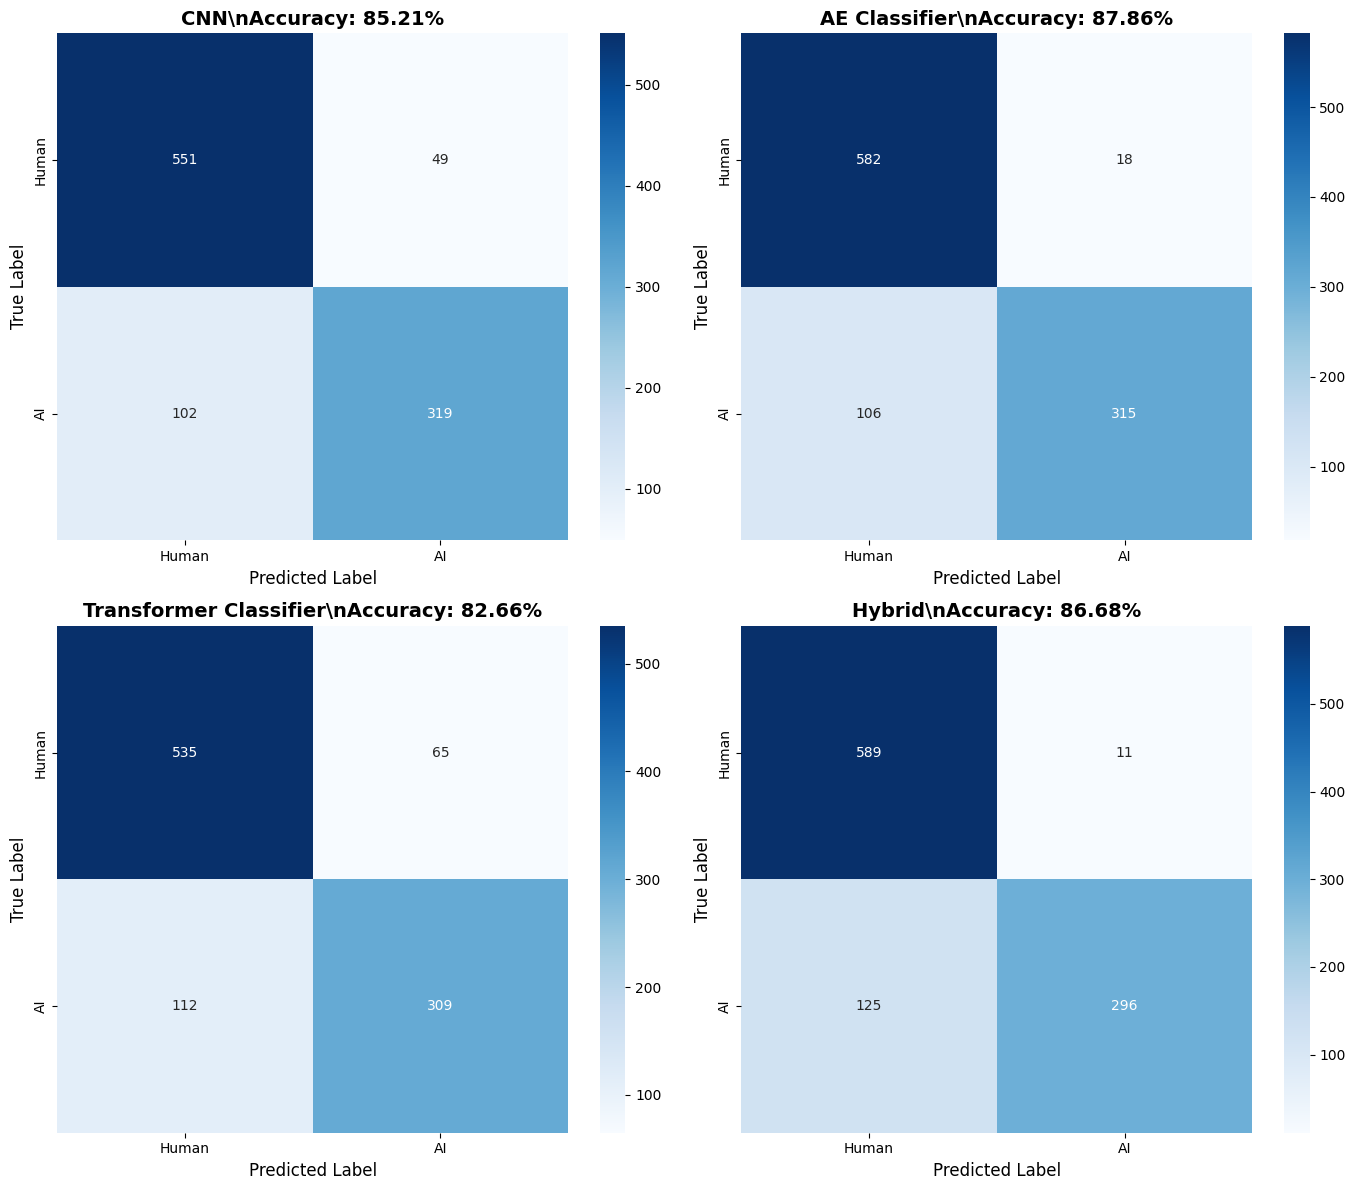

✓ Confusion matrices saved to results/confusion_matrices.png


In [48]:
if RUN_PHASE_5_EVALUATE:
    print("\\n Generating confusion matrices...\\n")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for idx, (name, results) in enumerate(evaluation_results.items()):
        cm = results['confusion_matrix']
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                    xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
        axes[idx].set_title(f'{name}\\nAccuracy: {results["accuracy"]*100:.2f}%', fontsize=14, fontweight='bold')
        axes[idx].set_ylabel('True Label', fontsize=12)
        axes[idx].set_xlabel('Predicted Label', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/results/confusion_matrices.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Confusion matrices saved to results/confusion_matrices.png")

### 5.5 Plot ROC Curves

\n Plotting ROC curves...\n


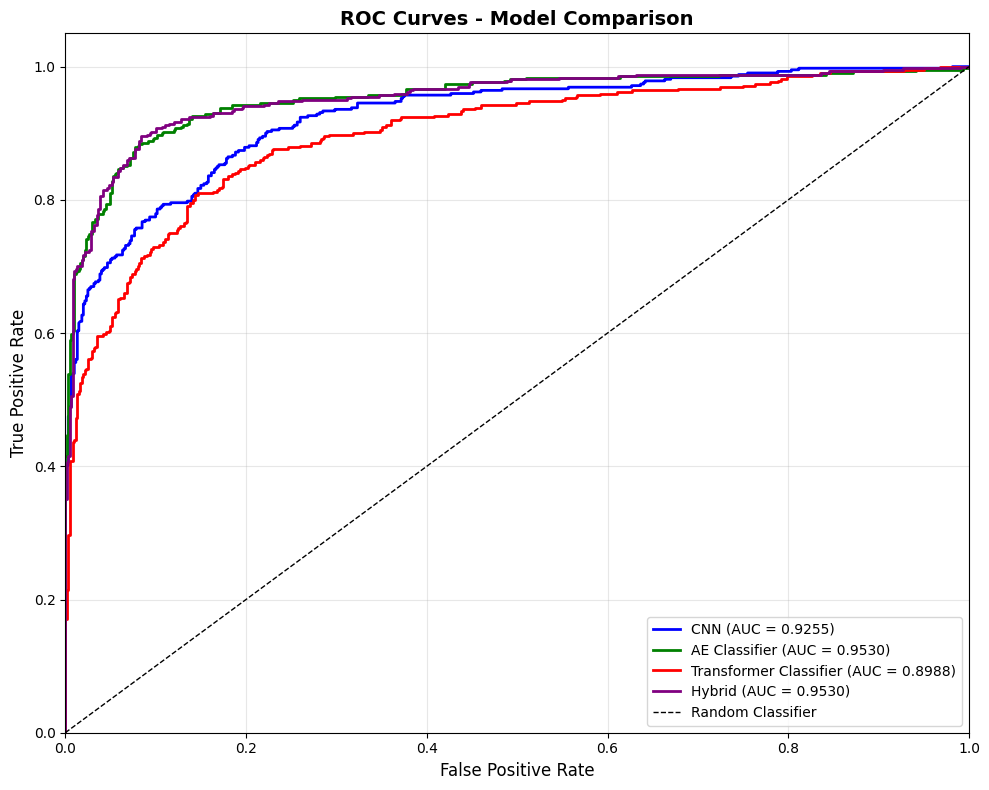

✓ ROC curves saved to results/roc_curves.png


In [49]:
if RUN_PHASE_5_EVALUATE:
    print("\\n Plotting ROC curves...\\n")
    
    plt.figure(figsize=(10, 8))
    
    colors = ['blue', 'green', 'red', 'purple']
    
    for (name, results), color in zip(evaluation_results.items(), colors):
        fpr, tpr, _ = roc_curve(results['labels'], results['probabilities'])
        plt.plot(fpr, tpr, color=color, linewidth=2, 
                label=f'{name} (AUC = {results["roc_auc"]:.4f})')
    
    # Plot diagonal
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/results/roc_curves.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ ROC curves saved to results/roc_curves.png")

### 5.6 Generate t-SNE Visualizations

\n Generating t-SNE visualizations (this may take a few minutes)...\n
Computing t-SNE for AE Latents...
Computing t-SNE for Transformer Embeddings...
Computing t-SNE for Hybrid Features...


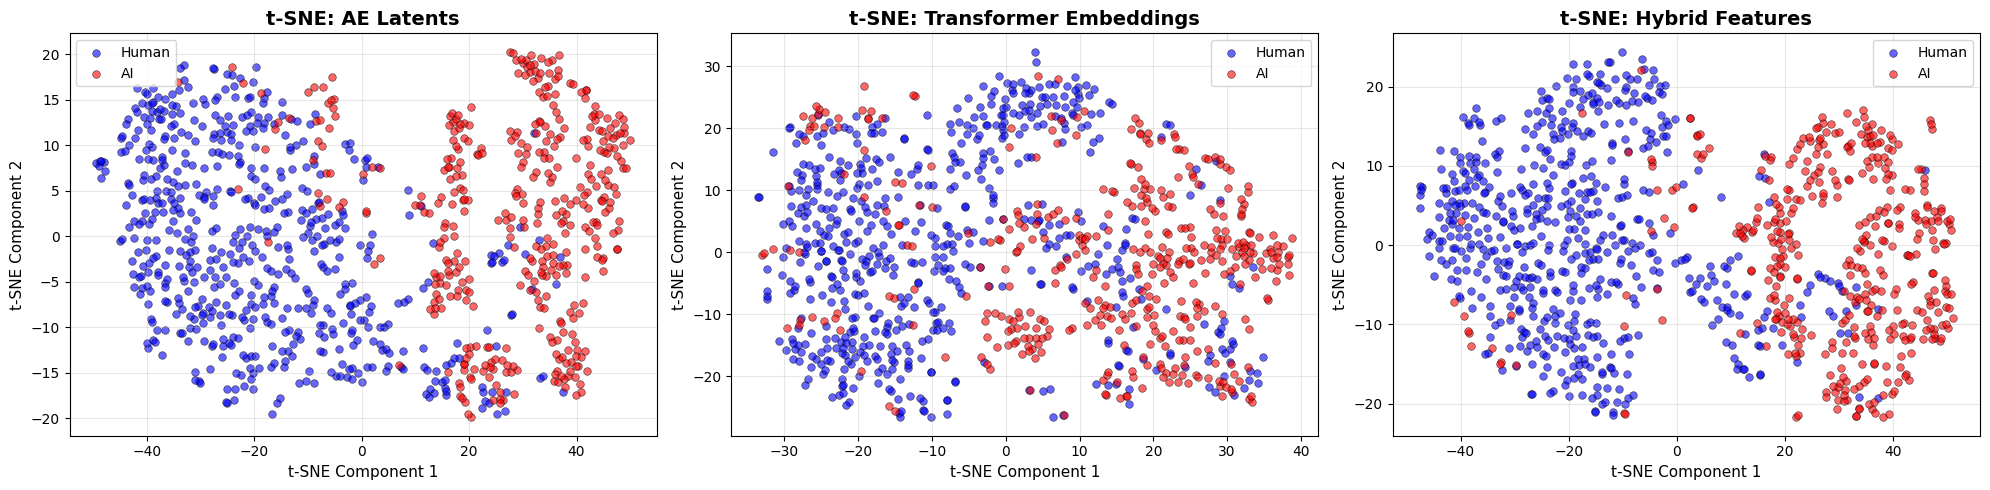

\n✓ t-SNE visualizations saved to results/tsne_visualizations.png
CPU times: user 29.7 s, sys: 66 ms, total: 29.8 s
Wall time: 15.3 s


In [50]:
%%time
if RUN_PHASE_5_EVALUATE:
    from sklearn.manifold import TSNE
    
    print("\\n Generating t-SNE visualizations (this may take a few minutes)...\\n")
    
    # Use a subset for t-SNE (it's computationally expensive)
    n_samples = min(1000, len(test_hybrid_features))
    indices = np.random.choice(len(test_hybrid_features), n_samples, replace=False)
    
    # Prepare data for t-SNE
    tsne_data = [
        ("AE Latents", test_latents[indices]),
        ("Transformer Embeddings", test_embeddings[indices]),
        ("Hybrid Features", test_hybrid_features[indices])
    ]
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    
    for idx, (name, features) in enumerate(tsne_data):
        print(f"Computing t-SNE for {name}...")
        
        # Compute t-SNE
        tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30, n_iter=1000)
        features_2d = tsne.fit_transform(features)
        
        # Plot
        labels_subset = y_test[indices]
        scatter = axes[idx].scatter(
            features_2d[labels_subset == 0, 0], 
            features_2d[labels_subset == 0, 1],
            c='blue', alpha=0.6, s=30, label='Human', edgecolors='k', linewidth=0.5
        )
        axes[idx].scatter(
            features_2d[labels_subset == 1, 0], 
            features_2d[labels_subset == 1, 1],
            c='red', alpha=0.6, s=30, label='AI', edgecolors='k', linewidth=0.5
        )
        
        axes[idx].set_title(f't-SNE: {name}', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('t-SNE Component 1', fontsize=11)
        axes[idx].set_ylabel('t-SNE Component 2', fontsize=11)
        axes[idx].legend(fontsize=10)
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/results/tsne_visualizations.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\\n✓ t-SNE visualizations saved to results/tsne_visualizations.png")

### 5.7 Create Model Comparison Table

\n Creating model comparison table...\n
                 Model Accuracy (%) Precision Recall F1-Score ROC-AUC
         AE Classifier        87.86    0.9459 0.7482   0.8355  0.9530
                Hybrid        86.68    0.9642 0.7031   0.8132  0.9530
                   CNN        85.21    0.8668 0.7577   0.8086  0.9255
Transformer Classifier        82.66    0.8262 0.7340   0.7774  0.8988


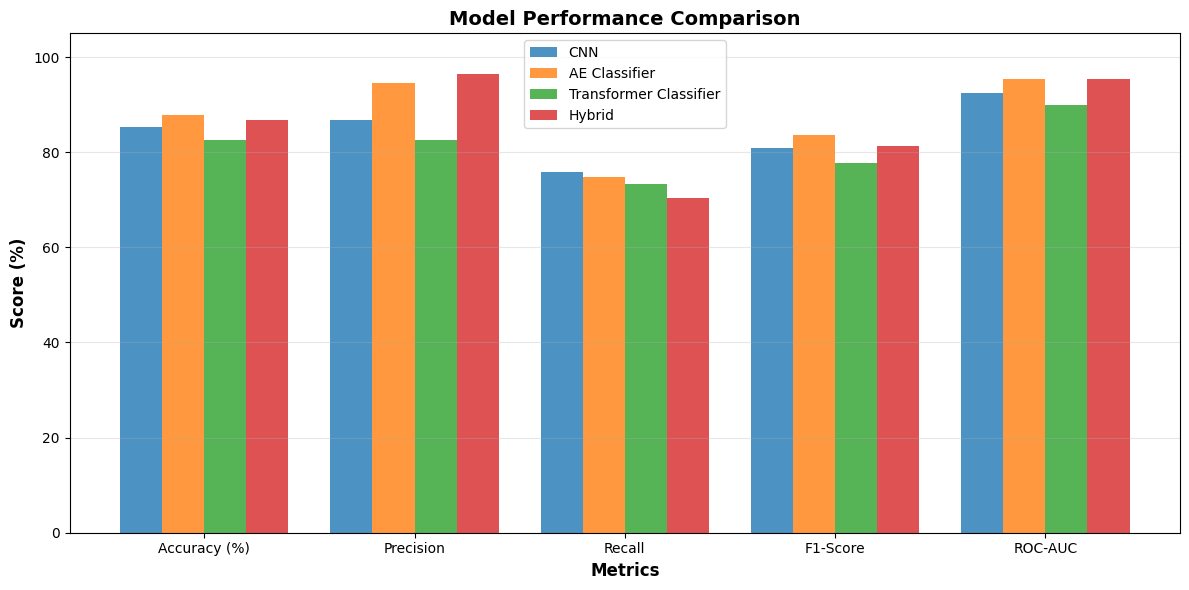

\n✓ Comparison table saved to results/model_comparison_table.csv
✓ Comparison chart saved to results/model_comparison_chart.png


In [51]:
if RUN_PHASE_5_EVALUATE:
    print("\\n Creating model comparison table...\\n")
    
    # Create comparison dataframe
    comparison_data = []
    
    for name, results in evaluation_results.items():
        comparison_data.append({
            'Model': name,
            'Accuracy (%)': f"{results['accuracy']*100:.2f}",
            'Precision': f"{results['precision']:.4f}",
            'Recall': f"{results['recall']:.4f}",
            'F1-Score': f"{results['f1']:.4f}",
            'ROC-AUC': f"{results['roc_auc']:.4f}"
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    
    # Sort by accuracy (descending)
    df_comparison['Accuracy_num'] = df_comparison['Accuracy (%)'].astype(float)
    df_comparison = df_comparison.sort_values('Accuracy_num', ascending=False).drop('Accuracy_num', axis=1)
    
    # Display table
    print(df_comparison.to_string(index=False))
    
    # Save to CSV
    df_comparison.to_csv(f"{OUTPUT_DIR}/results/model_comparison_table.csv", index=False)
    
    # Create a nice visualization of the comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    
    metrics = ['Accuracy (%)', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    x = np.arange(len(metrics))
    width = 0.2
    
    for idx, (name, results) in enumerate(evaluation_results.items()):
        values = [
            results['accuracy']*100,
            results['precision']*100,
            results['recall']*100,
            results['f1']*100,
            results['roc_auc']*100
        ]
        ax.bar(x + idx*width, values, width, label=name, alpha=0.8)
    
    ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
    ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(metrics)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 105])
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/results/model_comparison_chart.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\\n✓ Comparison table saved to results/model_comparison_table.csv")
    print("✓ Comparison chart saved to results/model_comparison_chart.png")

### 5.8 Save Complete Evaluation Results

In [52]:
if RUN_PHASE_5_EVALUATE:
    print("\\n Saving complete evaluation results...\\n")
    
    # Prepare results for JSON serialization
    results_for_json = {}
    
    for name, results in evaluation_results.items():
        results_for_json[name] = {
            'accuracy': float(results['accuracy']),
            'precision': float(results['precision']),
            'recall': float(results['recall']),
            'f1_score': float(results['f1']),
            'roc_auc': float(results['roc_auc']),
            'confusion_matrix': results['confusion_matrix'].tolist()
        }
    
    # Add dataset information
    results_for_json['dataset_info'] = {
        'total_samples': len(spectrograms),
        'train_samples': len(X_train),
        'val_samples': len(X_val),
        'test_samples': len(X_test),
        'ai_test_samples': int(np.sum(y_test == 1)),
        'human_test_samples': int(np.sum(y_test == 0))
    }
    
    # Add configuration
    results_for_json['configuration'] = {
        'sample_rate': SAMPLE_RATE,
        'duration': DURATION,
        'n_mels': N_MELS,
        'ae_latent_dim': AE_LATENT_DIM,
        'transformer_dim': TRANSFORMER_DIM,
        'hybrid_dim': HYBRID_DIM,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'random_seed': RANDOM_SEED
    }
    
    # Save to JSON
    with open(f"{OUTPUT_DIR}/results/evaluation_metrics.json", 'w') as f:
        json.dump(results_for_json, f, indent=2)
    
    print("✓ Complete results saved to results/evaluation_metrics.json")
    
    # Print summary
    print("\\n" + "="*80)
    print(" EVALUATION SUMMARY")
    print("="*80)
    
    print(f"\\nBest Performing Model:")
    best_model = max(evaluation_results.items(), key=lambda x: x[1]['accuracy'])
    print(f"  {best_model[0]}")
    print(f"  Accuracy: {best_model[1]['accuracy']*100:.2f}%")
    print(f"  F1-Score: {best_model[1]['f1']:.4f}")
    print(f"  ROC-AUC: {best_model[1]['roc_auc']:.4f}")
    
    print("\\n" + "="*80)
    print(" PHASE 5 COMPLETE: Evaluation & Visualization")
    print("="*80)
    
    print(f"\\nAll outputs saved to: {OUTPUT_DIR}/results/")
    print(f"\\nGenerated files:")
    print(f"  ✓ confusion_matrices.png")
    print(f"  ✓ roc_curves.png")
    print(f"  ✓ tsne_visualizations.png")
    print(f"  ✓ model_comparison_table.csv")
    print(f"  ✓ model_comparison_chart.png")
    print(f"  ✓ evaluation_metrics.json")
    
    print("\\n" + "="*80)
    print("PROJECT COMPLETE!")
    print("="*80)
    print(f"\\nHybrid Transformer-Autoencoder Synthetic Music Detection")
    print(f"Group 28: Minahil Ali, Ayaan Khan, Atif Ibrahim Abasi")
    print(f"\\nAll phases completed successfully! ")

\n Saving complete evaluation results...\n
✓ Complete results saved to results/evaluation_metrics.json
\n================================================================================
 EVALUATION SUMMARY
\nBest Performing Model:
  AE Classifier
  Accuracy: 87.86%
  F1-Score: 0.8355
  ROC-AUC: 0.9530
\n================================================================================
 PHASE 5 COMPLETE: Evaluation & Visualization
\nAll outputs saved to: /kaggle/working/results/
\nGenerated files:
  ✓ confusion_matrices.png
  ✓ roc_curves.png
  ✓ tsne_visualizations.png
  ✓ model_comparison_table.csv
  ✓ model_comparison_chart.png
  ✓ evaluation_metrics.json
\n================================================================================
PROJECT COMPLETE!
\nHybrid Transformer-Autoencoder Synthetic Music Detection
Group 28: Minahil Ali, Ayaan Khan, Atif Ibrahim Abasi
\nAll phases completed successfully! 


## Download Zip

In [ ]:
!cd /kaggle/working/ && zip -r working_dir.zip .

updating: embeddings/ (stored 0%)
updating: embeddings/ae_latents.npz (deflated 0%)
updating: embeddings/ae_losses.npz (deflated 0%)
updating: embeddings/transformer_embeddings.npz (deflated 0%)
updating: splits.json (deflated 53%)
updating: .virtual_documents/ (stored 0%)
updating: checkpoints/ (stored 0%)
updating: checkpoints/transformer_classifier_last.pth (deflated 8%)
updating: checkpoints/ae_classifier_best.pth (deflated 9%)
updating: checkpoints/ae_last.pth (deflated 8%)
updating: checkpoints/cnn_best.pth (deflated 8%)
updating: checkpoints/cnn_last.pth (deflated 8%)
updating: checkpoints/hybrid_best.pth (deflated 8%)
updating: checkpoints/ae_best.pth (deflated 8%)
updating: checkpoints/hybrid_last.pth (deflated 8%)
updating: checkpoints/transformer_classifier_best.pth (deflated 8%)
updating: checkpoints/ae_classifier_last.pth (deflated 9%)
updating: preprocessed_data.npz